# Análise explorátoria dos dados de treino/teste

https://www.kaggle.com/datasets/computingvictor/transactions-fraud-datasets

In [2]:
!pip install prince -q

##  Importação de bibliotecas e dados

In [3]:
import os
import umap
import spacy
import prince
import shutil
import hdbscan
import tabulate
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from itertools import combinations
from scipy.stats import chi2_contingency
from sentence_transformers import SentenceTransformer

from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 79.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_notarget.parquet'  ,'/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_train_test.parquet','/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_validation.parquet','/content/datasets/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df = pd.read_parquet('./datasets/df_train_test.parquet', engine='pyarrow')
df.head()

id                date  client_id  card_id  amount           use_chip  \
0  7475327 2010-01-01 00:01:00       1556     2972  -77.00  Swipe Transaction   
1  7475328 2010-01-01 00:02:00        561     4575   14.57  Swipe Transaction   
2  7475329 2010-01-01 00:02:00       1129      102   80.00  Swipe Transaction   
3  7475332 2010-01-01 00:06:00        848     3915   46.41  Swipe Transaction   
4  7475333 2010-01-01 00:07:00       1807      165    4.81  Swipe Transaction   

   merchant_id merchant_city merchant_state      zip  ...        card_type  \
0        59935        Beulah             ND  58523.0  ...  Debit (Prepaid)   
1        67570    Bettendorf             IA  52722.0  ...           Credit   
2        27092         Vista             CA  92084.0  ...            Debit   
3        13051       Harwood             MD  20776.0  ...            Debit   
4        20519         Bronx             NY  10464.0  ...  Debit (Prepaid)   

        card_number  expires  cvv  has_chip  num_cards_issued  credit_limit  \
0  5497590243197280  07/2022  306       YES                 2          55.0   
1  5175842699412235  12/2024  438       YES                 1        9100.0   
2  5874992802287595  05/2020  256       YES                 1       14802.0   
3  4354185735186651  01/2020  120       YES                 1       19113.0   
4  5207231566469664  03/2014  198       YES                 1          89.0   

   acct_open_date year_pin_last_changed card_on_dark_web  
0         05/2008                  2008               No  
1         09/2005                  2015               No  
2         01/2006                  2008               No  
3         07/2009                  2014               No  
4         01/2008                  2015               No  

[5 rows x 38 columns]

## Ajuste no tipo de dado

In [7]:
df['target'].value_counts()

target
No     7394705
Yes      10665
Name: count, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7405370 entries, 0 to 7405369
Data columns (total 38 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   id                     int64         
 1   date                   datetime64[ns]
 2   client_id              int64         
 3   card_id                int64         
 4   amount                 float64       
 5   use_chip               object        
 6   merchant_id            int64         
 7   merchant_city          object        
 8   merchant_state         object        
 9   zip                    float64       
 10  mcc                    object        
 11  errors                 object        
 12  description            object        
 13  target                 object        
 14  current_age            int64         
 15  retirement_age         int64         
 16  birth_year             int64         
 17  birth_month            int64         
 18  gender                

In [9]:
df['id'] = df['id'].astype(str)
df['client_id'] = df['client_id'].astype(str)
df['card_id'] = df['card_id'].astype(str)
df['merchant_id'] = df['merchant_id'].astype(str)
df['zip'] = df['zip'].astype(str)
df['card_number'] = df['card_number'].astype(str)
df['cvv'] = df['cvv'].astype(str)
df['birth_year'] = df['birth_year'].astype(str)
df['birth_month'] = df['birth_month'].astype(str)


1. **id**: Identificador único da transação.
2. **date**: Data em que a transação foi realizada.
3. **client_id**: Identificador único do cliente.
4. **card_id**: Identificador único do cartão utilizado na transação.
5. **amount**: Valor da transação.
6. **use_chip**: Indicador se a transação foi efetuada com o uso de chip (sim/não).
7. **merchant_id**: Identificador do comerciante onde a transação foi realizada.
8. **merchant_city**: Cidade onde está localizado o comerciante.
9. **merchant_state**: Estado onde está localizado o comerciante.
10. **zip**: Código postal do local do comerciante.
11. **mcc**: Código de Categoria do Comerciante, que indica o tipo de negócio ou setor do comerciante.
12. **errors**: Indicador de erros ocorridos durante a transação.
13. **description**: Descrição ou comentário associado à transação.
14. **target**: Indicador se a transação foi fraudulenta (Yes) ou não (No).
15. **current_age**: Idade atual do cliente.
16. **retirement_age**: Idade de aposentadoria do cliente.
17. **birth_year**: Ano de nascimento do cliente.
18. **birth_month**: Mês de nascimento do cliente.
19. **gender**: Gênero do cliente.
20. **address**: Endereço residencial do cliente.
21. **latitude**: Latitude do endereço do cliente.
22. **longitude**: Longitude do endereço do cliente.
23. **per_capita_income**: Renda per capita do cliente ou região.
24. **yearly_income**: Renda anual do cliente.
25. **total_debt**: Dívida total do cliente.
26. **credit_score**: Pontuação de crédito do cliente.
27. **num_credit_cards**: Número de cartões de crédito que o cliente possui.
28. **card_brand**: Bandeira do cartão utilizado na transação (Visa, Mastercard, etc.).
29. **card_type**: Tipo do cartão (crédito, débito, etc.).
30. **card_number**: Número do cartão utilizado na transação.
31. **expires**: Data de expiração do cartão.
32. **cvv**: Código de segurança do cartão.
33. **has_chip**: Indicador se o cartão possui chip (sim/não).
34. **num_cards_issued**: Número de cartões emitidos para o cliente.
35. **credit_limit**: Limite de crédito do cartão.
36. **acct_open_date**: Data de abertura da conta do cliente.
37. **year_pin_last_cha**: Ano da última alteração do PIN do cartão.
38. **card_on_dark_web**: Indicador se o cartão foi encontrado em listas de venda na dark web.

## Análise dos dados

In [10]:
def descritiva(df_, var, vresp: str, max_classes=5, map_target: dict|None = None):
    df = df_[[var, vresp]].copy()

    if df[var].dtype in [np.float64, np.int64]:
      if df[var].nunique()>max_classes:
          df[var] = pd.qcut(df[var], max_classes, duplicates='drop')

    if map_target is not None:
      df[vresp] = df[vresp].map(map_target)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1 = sns.countplot(data=df, x=var, palette='viridis', alpha=0.5, ax=ax1)
    ax1.set_ylabel('Frequência', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    for p in ax1.patches:
        ax1.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    ax2 = ax1.twinx()

    sns.pointplot(data=df, y=vresp, x=var, ax=ax2)
    ax2.set_ylabel(vresp, color='red')

    ax1.set_zorder(2)
    ax1.patch.set_visible(False)  # Tornar o fundo do eixo 1 transparente

    # Exibir o gráfico
    plt.show()
    del df

### Análise temporal

In [11]:
df_time = pd.DataFrame()
df_time['year'] = df['date'].dt.to_period('Y')
df_time['year_month'] = df['date'].dt.to_period('M').dt.to_timestamp(how='start')
df_time['target'] = df['target']
df_time.head()

year year_month target
0  2010 2010-01-01     No
1  2010 2010-01-01     No
2  2010 2010-01-01     No
3  2010 2010-01-01     No
4  2010 2010-01-01     No

In [12]:
df_time_year = pd.pivot_table(df_time, index='year', columns='target', aggfunc='count').reset_index()
df_time_year.columns = ['year', 'target_no', 'target_yes']
df_time_year['total'] = df_time_year['target_no'] + df_time_year['target_yes']
df_time_year['percent_no'] = df_time_year['target_no'] / df_time_year['total']
df_time_year['percent_yes'] = df_time_year['target_yes'] / df_time_year['total']
df_time_year

year  target_no  target_yes   total  percent_no  percent_yes
0  2010     828956        2573  831529    0.996906     0.003094
1  2011     863391          37  863428    0.999957     0.000043
2  2012     884498         923  885421    0.998958     0.001042
3  2013     905967        1337  907304    0.998526     0.001474
4  2014     914409         664  915073    0.999274     0.000726
5  2015     928035        2189  930224    0.997647     0.002353
6  2016     930314        2448  932762    0.997376     0.002624
7  2017     937112         172  937284    0.999816     0.000184
8  2018     202023         322  202345    0.998409     0.001591

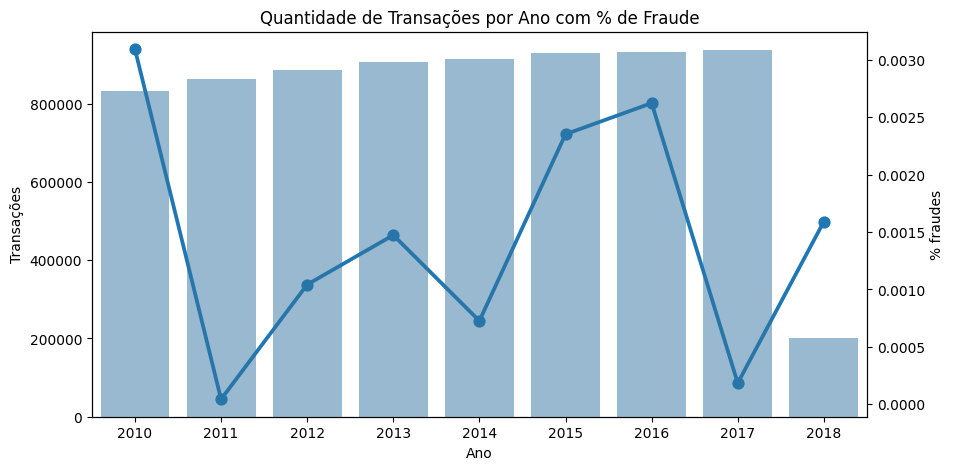

In [13]:
fig, ax1 = plt.subplots(figsize=(10, 5))
plt.title('Quantidade de Transações por Ano com % de Fraude')
sns.barplot(data=df_time_year, x='year', y='total', alpha=0.5, ax=ax1)
ax1.set_ylabel('Transações')
ax1.set_xlabel('Ano')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
sns.pointplot(data=df_time_year, y='percent_yes', x='year', ax=ax2)

ax2.set_ylabel('% fraudes')

ax1.set_zorder(2)
ax1.patch.set_visible(False)

plt.show()

del df_time_year

In [14]:
df_time = pd.DataFrame()
df_time['year'] = df['date'].dt.to_period('Y')
df_time['year_month'] = df['date'].dt.to_period('M').dt.to_timestamp(how='start')
df_time['amount'] = df['amount']
df_time['target'] = df['target']
df_time.head()

year year_month  amount target
0  2010 2010-01-01  -77.00     No
1  2010 2010-01-01   14.57     No
2  2010 2010-01-01   80.00     No
3  2010 2010-01-01   46.41     No
4  2010 2010-01-01    4.81     No

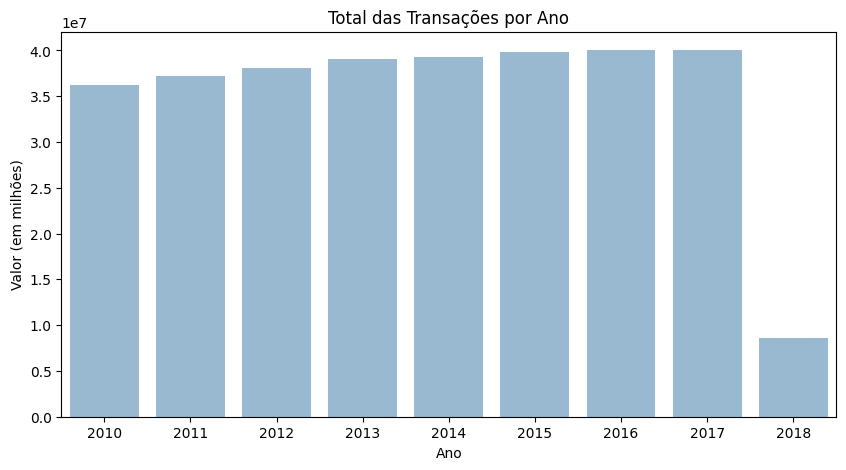

In [15]:
df_time_year = df_time.groupby(['year'])['amount'].sum().reset_index()

plt.subplots(figsize=(10, 5))
plt.title('Total das Transações por Ano')
sns.barplot(data=df_time_year, x='year', y='amount', alpha=0.5)
plt.ylabel('Valor (em milhões)')
plt.xlabel('Ano')

plt.show()

In [16]:
df_time_year = df_time.groupby(['year','target'])['amount'].sum().reset_index()
df_time_year['amount_million'] = df_time_year['amount'] / 1000000
df_time_year.head()

year target       amount  amount_million
0  2010     No  35918813.06       35.918813
1  2010    Yes    307936.83        0.307937
2  2011     No  37251408.65       37.251409
3  2011    Yes      4745.40        0.004745
4  2012     No  38004741.12       38.004741

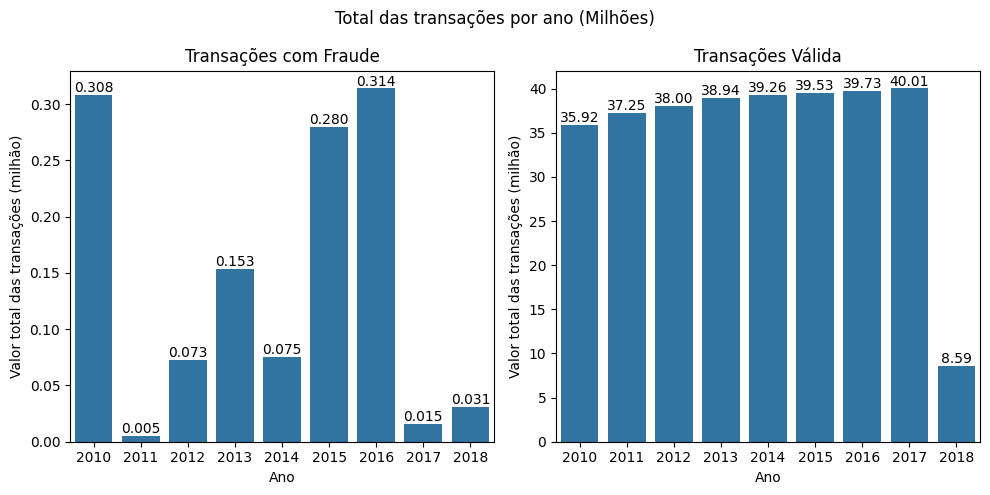

In [17]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title('Transações com Fraude')
ax1 = sns.barplot(data=df_time_year.query('target == "Yes"'), x='year', y='amount_million')
for patches in ax1.patches:
    ax1.annotate(f'{patches.get_height():.3f}', (patches.get_x() + patches.get_width() / 2., patches.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.ylabel('Valor total das transações (milhão)')
plt.xlabel('Ano')

plt.subplot(122)
plt.title('Transações Válida')
ax2 = sns.barplot(data=df_time_year.query('target == "No"'), x='year', y='amount_million')
for patches in ax2.patches:
    ax2.annotate(f'{patches.get_height():.2f}', (patches.get_x() + patches.get_width() / 2., patches.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.ylabel('Valor total das transações (milhão)')
plt.xlabel('Ano')

plt.suptitle('Total das transações por ano (Milhões)')
plt.tight_layout()
plt.show()

del df_time_year

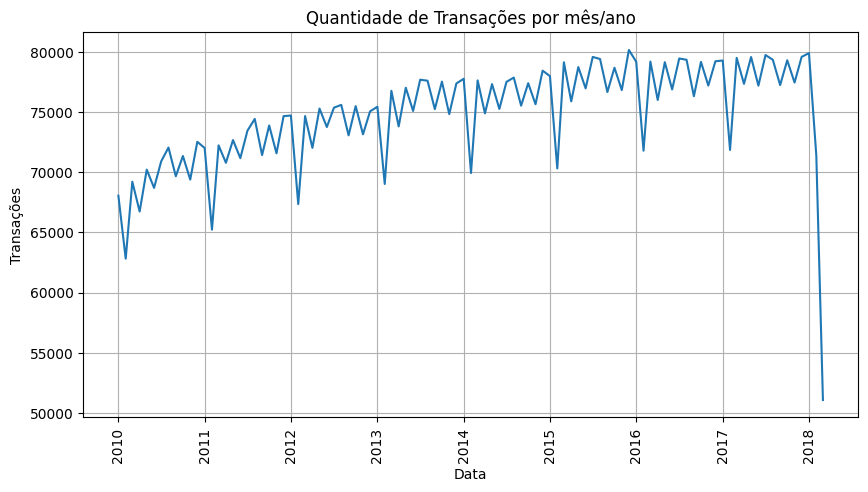

In [18]:
fig, ax1 = plt.subplots(figsize=(10, 5))
plt.title('Quantidade de Transações por mês/ano')
sns.lineplot(df_time['year_month'].value_counts().reset_index().sort_values('year_month', ascending=False).reset_index(drop=True), x='year_month', y='count', ax=ax1)
plt.xlabel('Data')
plt.ylabel('Transações')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [19]:
df_time_month = df_time.groupby(by=['year_month', 'target'])['amount'].agg(['sum', 'mean', 'std']).reset_index()
df_time_month['year'] = df_time_month['year_month'].dt.year
df_time_month['month'] = df_time_month['year_month'].dt.month
df_time_month['amount_million'] = df_time_month['sum'] / 1000000
df_time_month.head()

year_month target         sum        mean         std  year  month  \
0 2010-01-01     No  2929129.96   43.115386   82.574700  2010      1   
1 2010-01-01    Yes    12253.57  114.519346  203.905324  2010      1   
2 2010-02-01     No  2713507.09   43.376554   82.612872  2010      2   
3 2010-02-01    Yes    32488.11  125.436718  305.307738  2010      2   
4 2010-03-01     No  2984733.64   43.294029   83.392894  2010      3   

   amount_million  
0        2.929130  
1        0.012254  
2        2.713507  
3        0.032488  
4        2.984734

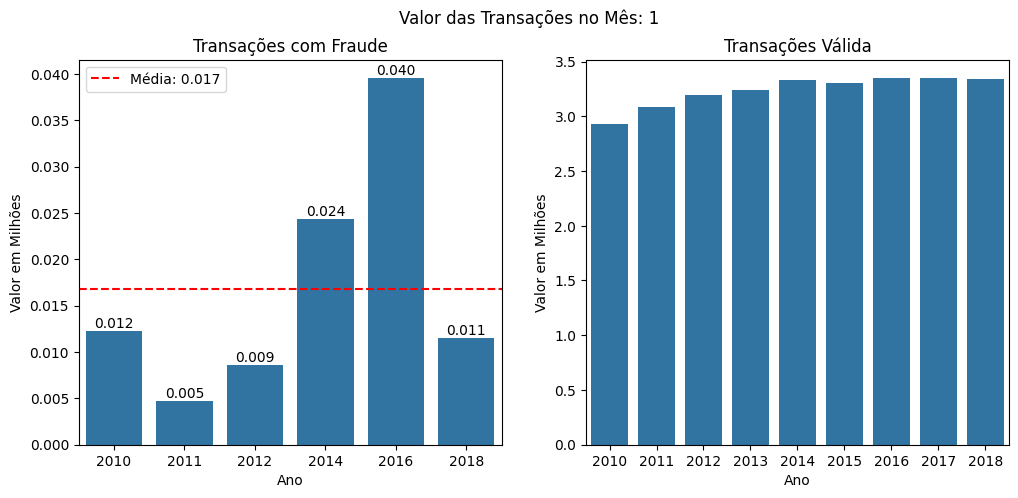

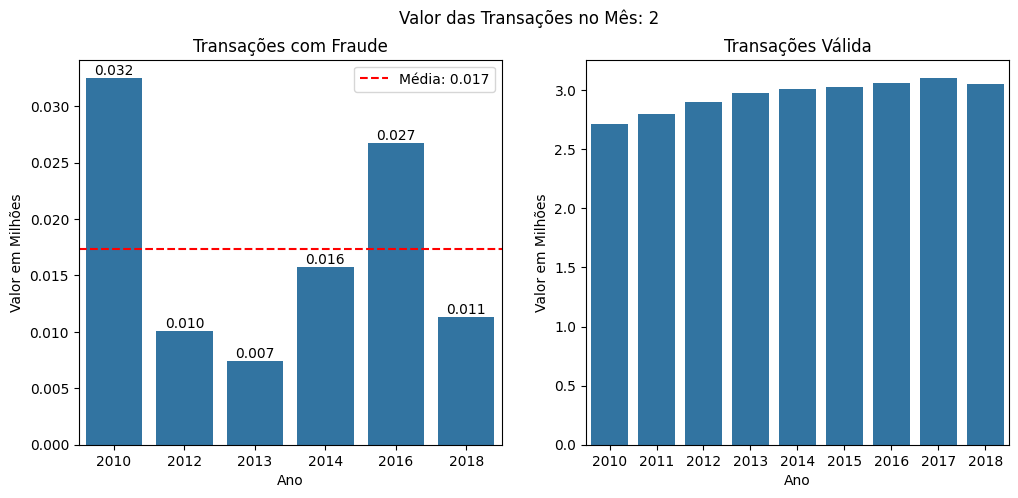

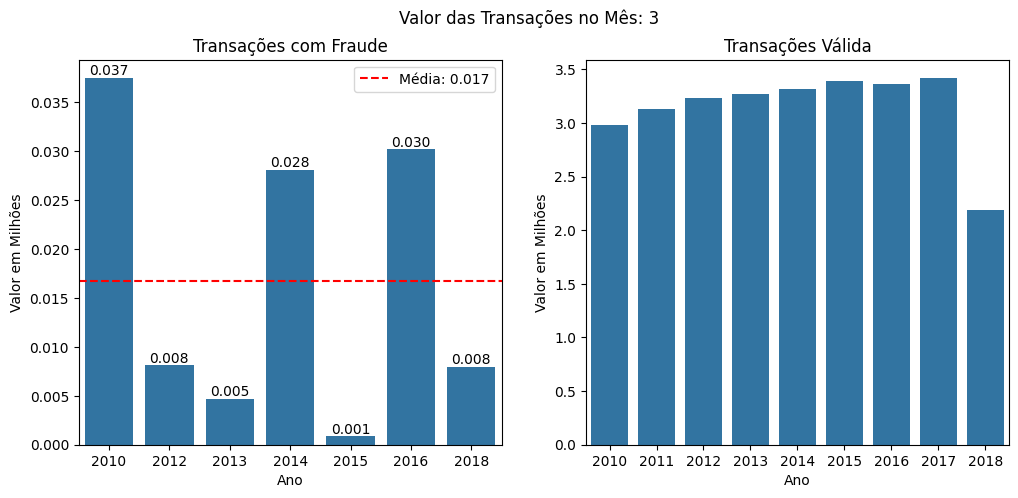

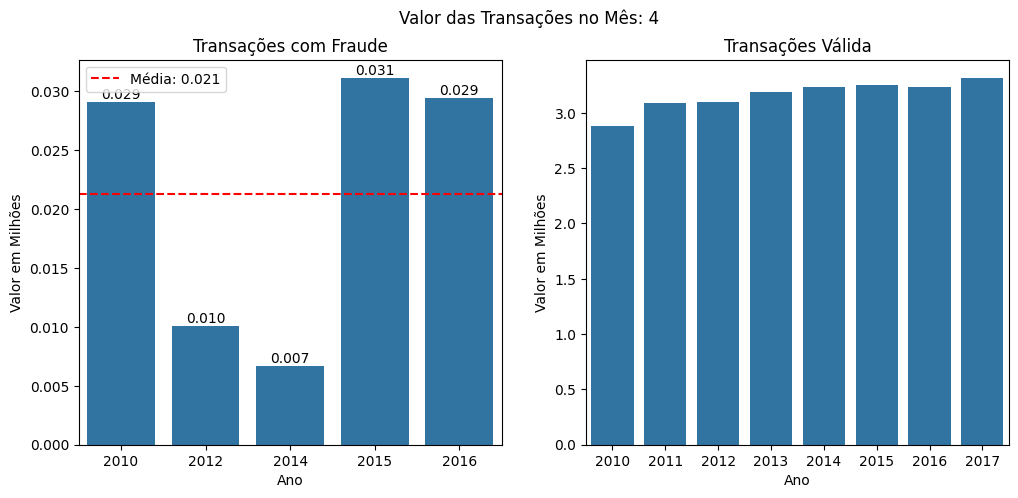

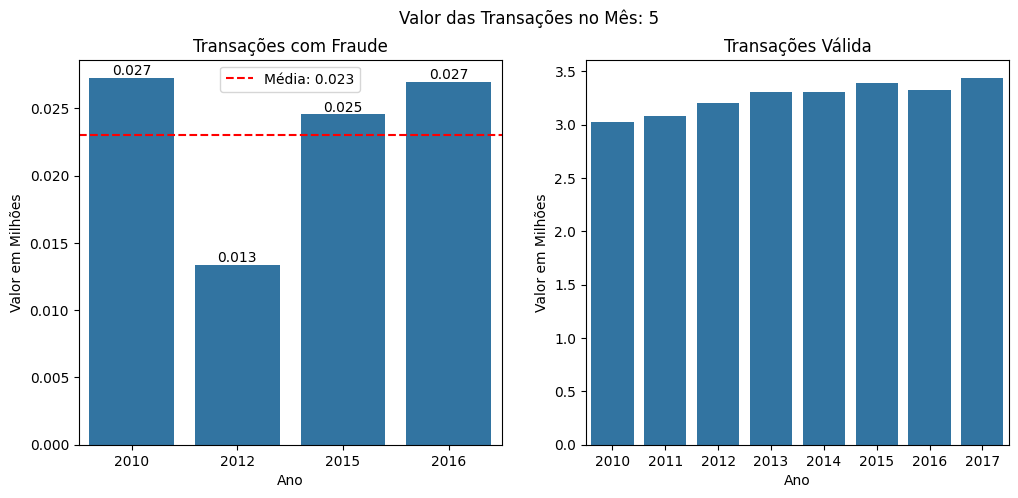

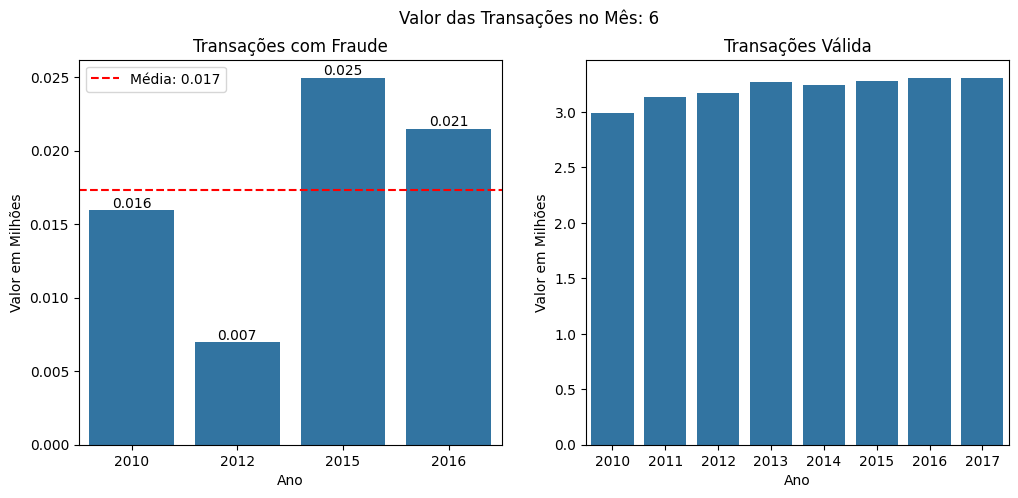

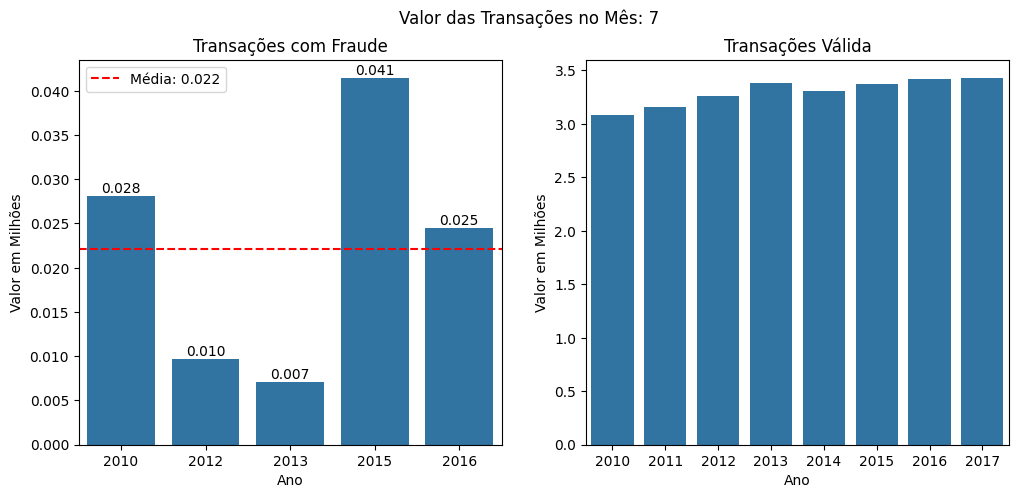

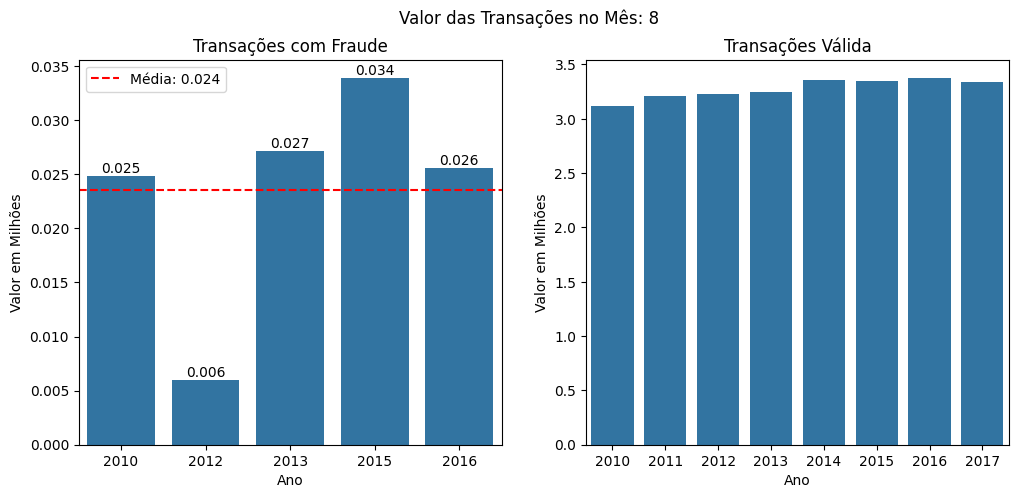

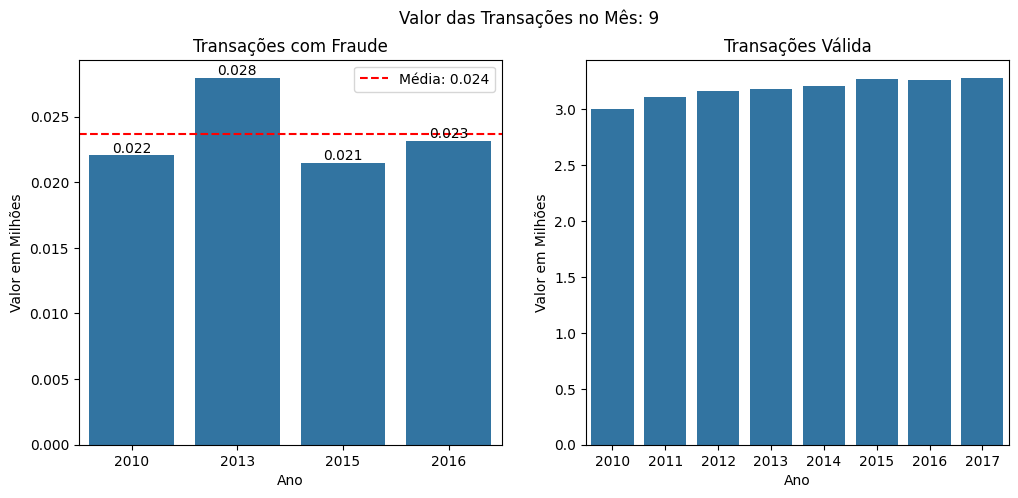

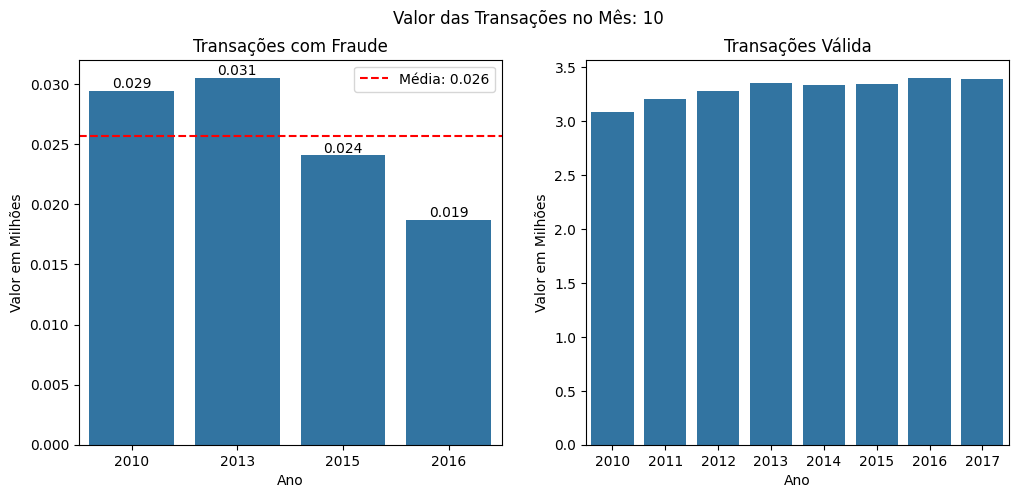

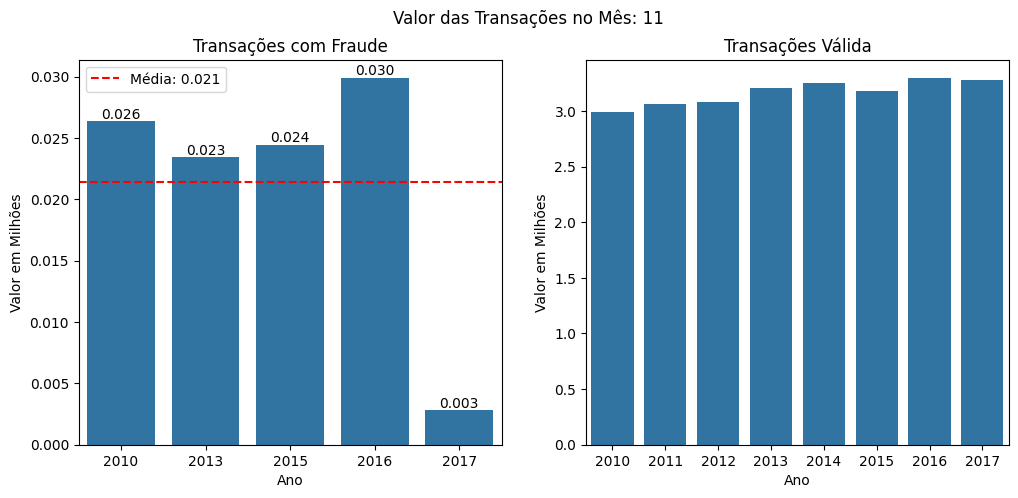

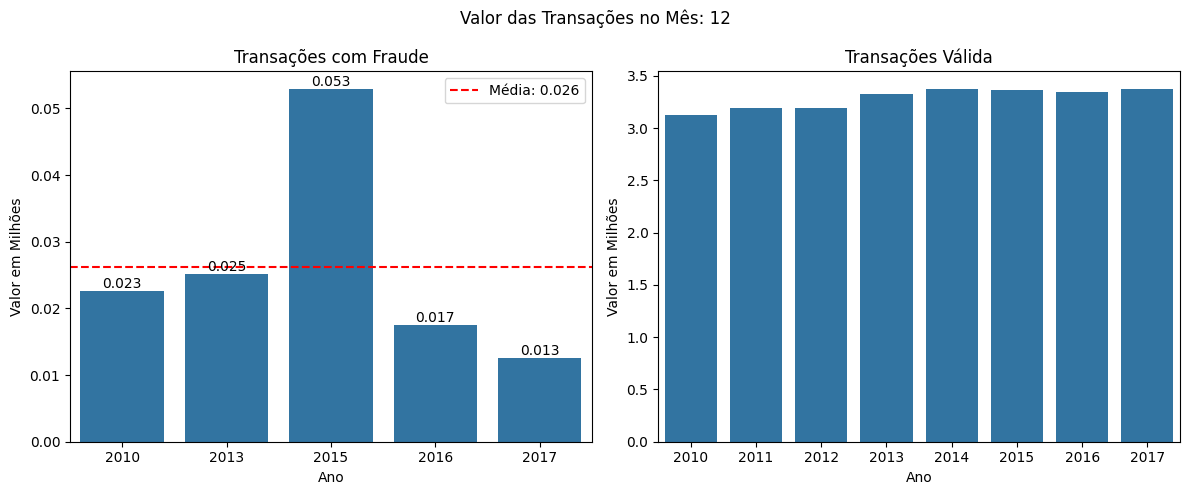

In [20]:
for month in df_time_month['month'].unique():
  df_time_month_month = df_time_month.query('month == @month')

  plt.figure(figsize=(12,5))
  plt.suptitle(f'Valor das Transações no Mês: {month}')

  plt.subplot(121)
  plt.title('Transações com Fraude')

  ax = sns.barplot(data=df_time_month_month.query('target == "Yes"'), x='year', y='amount_million')

  for patches in ax.patches:
    ax.annotate(f'{patches.get_height():.3f}', (patches.get_x() + patches.get_width() / 2., patches.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

  mean = df_time_month_month.query('target == "Yes"')['amount_million'].mean()
  ax.axhline(mean, color='red', linestyle='--', label=f'Média: {mean:.3f}')
  ax.legend()

  plt.ylabel('Valor em Milhões')
  plt.xlabel('Ano')

  plt.subplot(122)
  plt.title('Transações Válida')
  sns.barplot(data=df_time_month_month.query('target == "No"'), x='year', y='amount_million')
  plt.ylabel('Valor em Milhões')
  plt.xlabel('Ano')

plt.tight_layout()
plt.show()

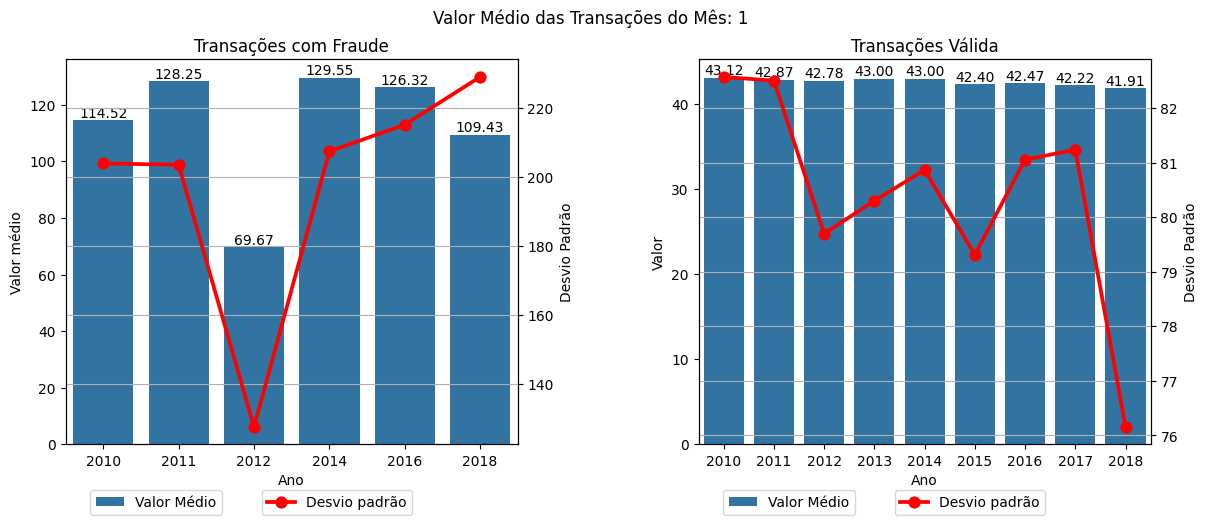

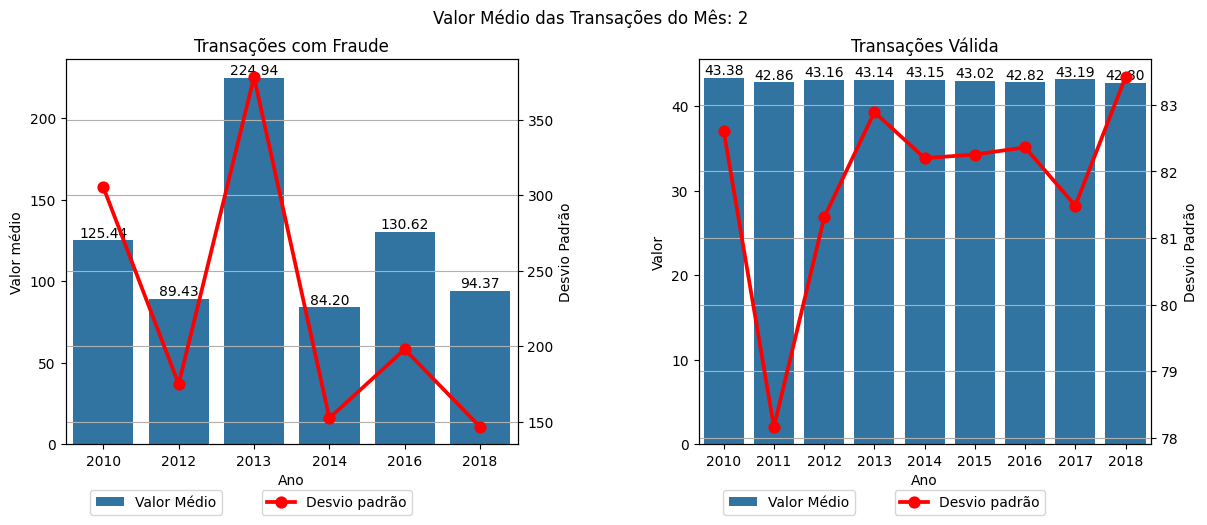

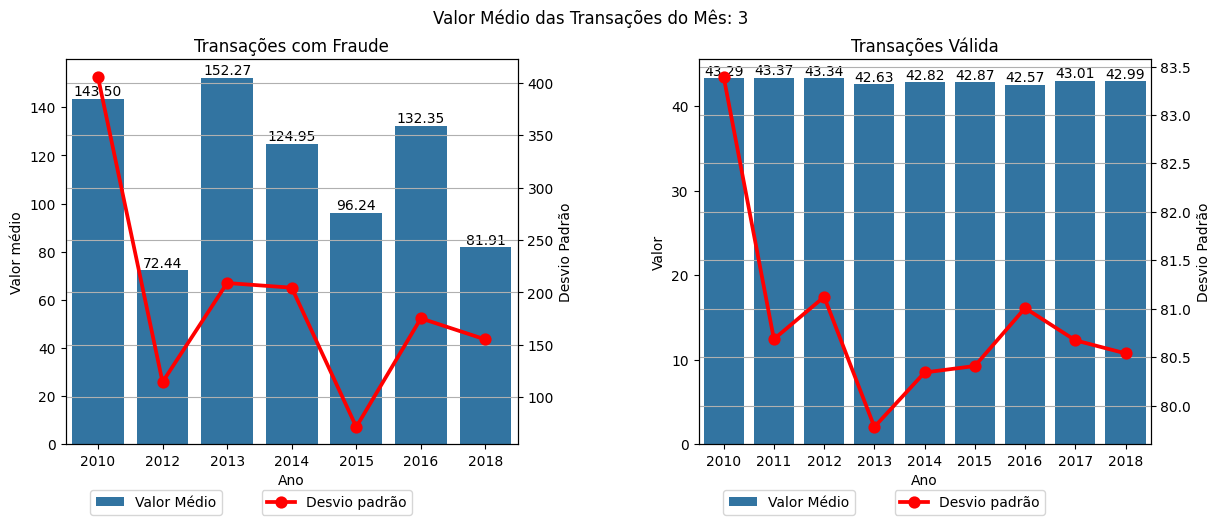

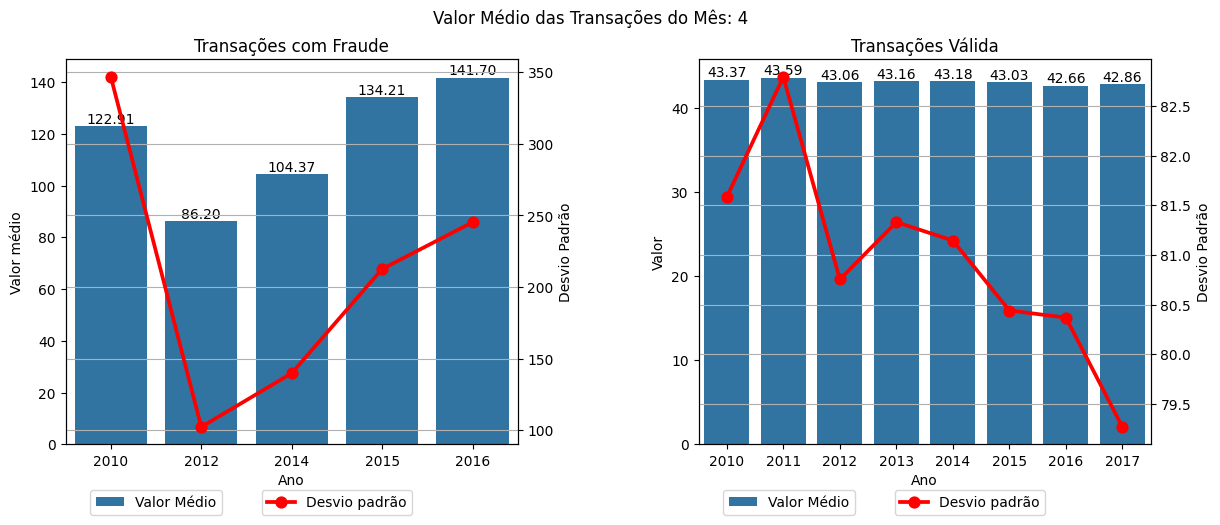

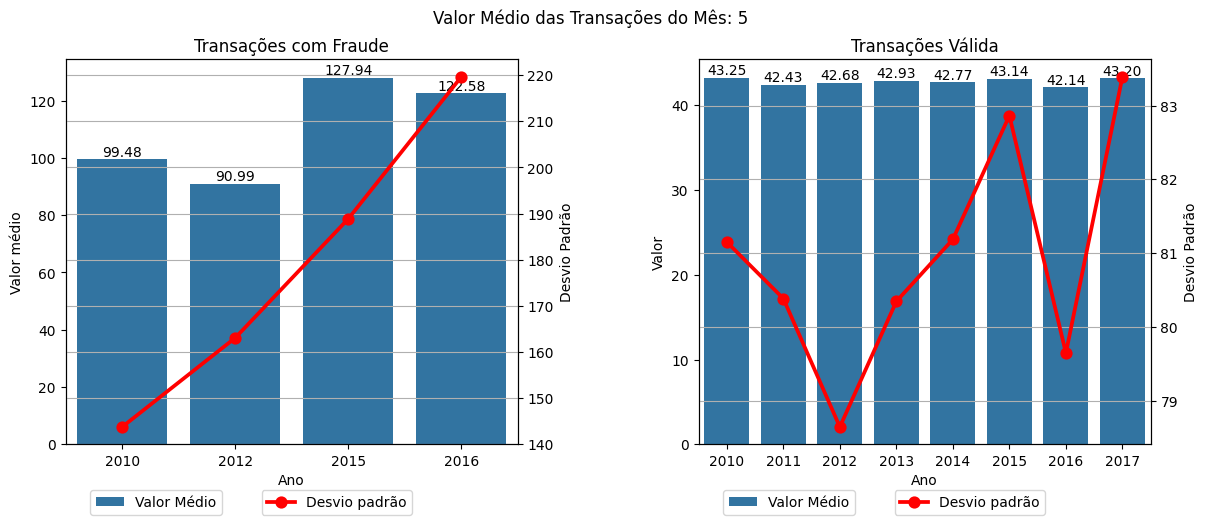

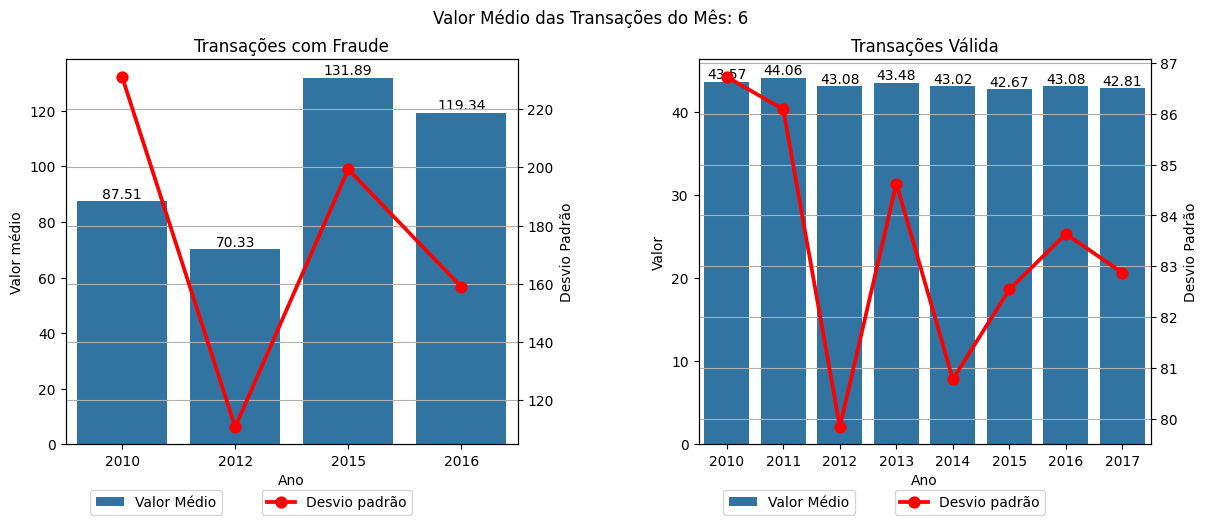

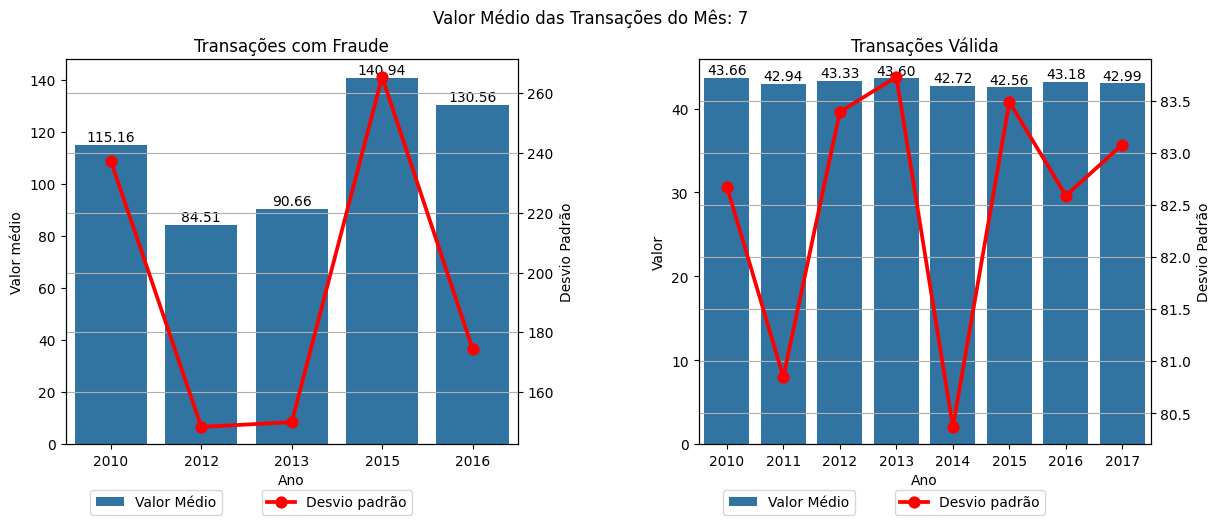

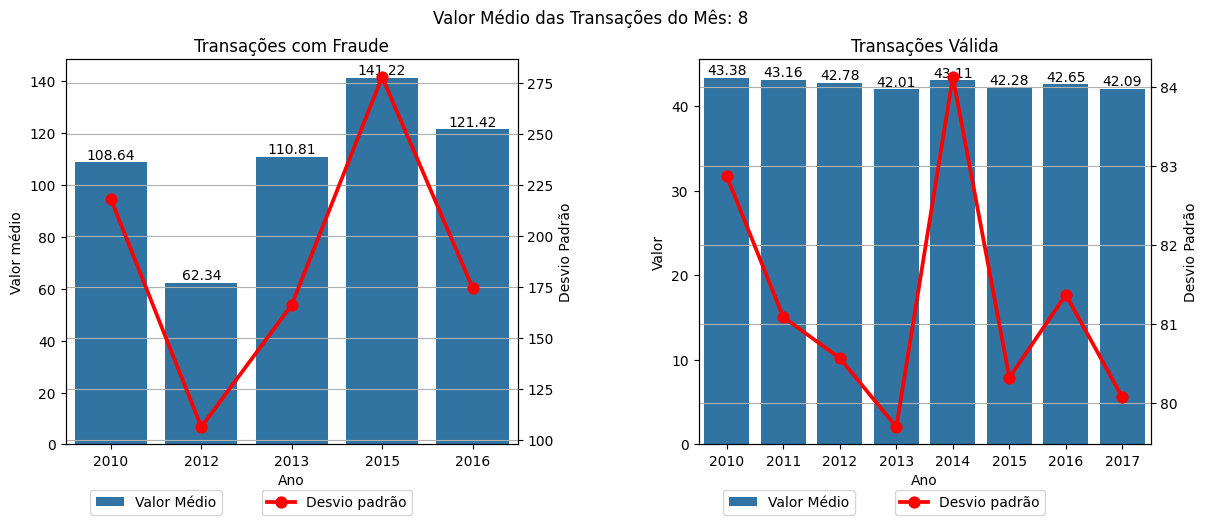

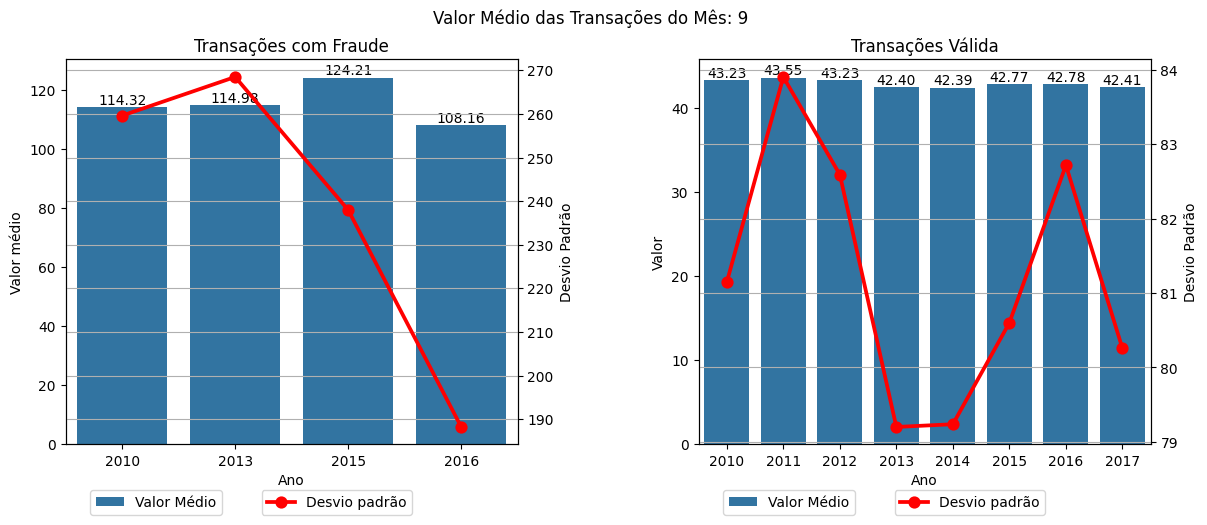

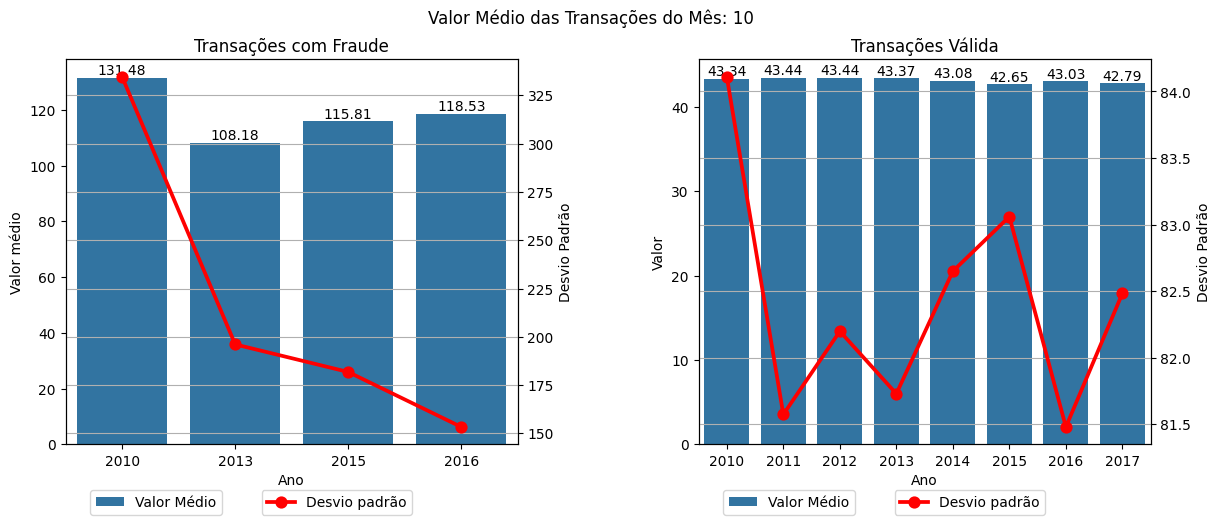

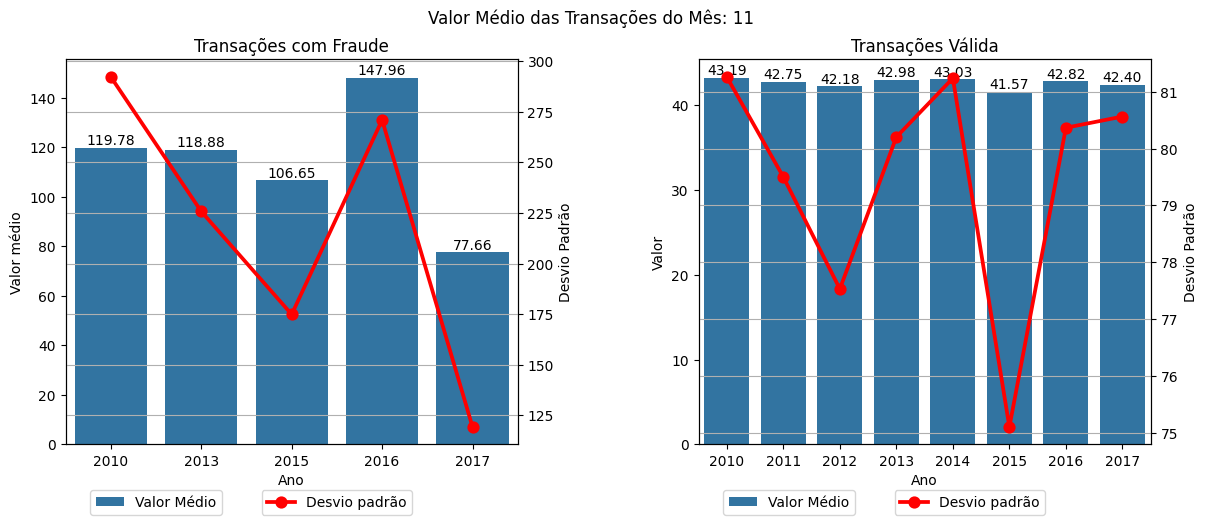

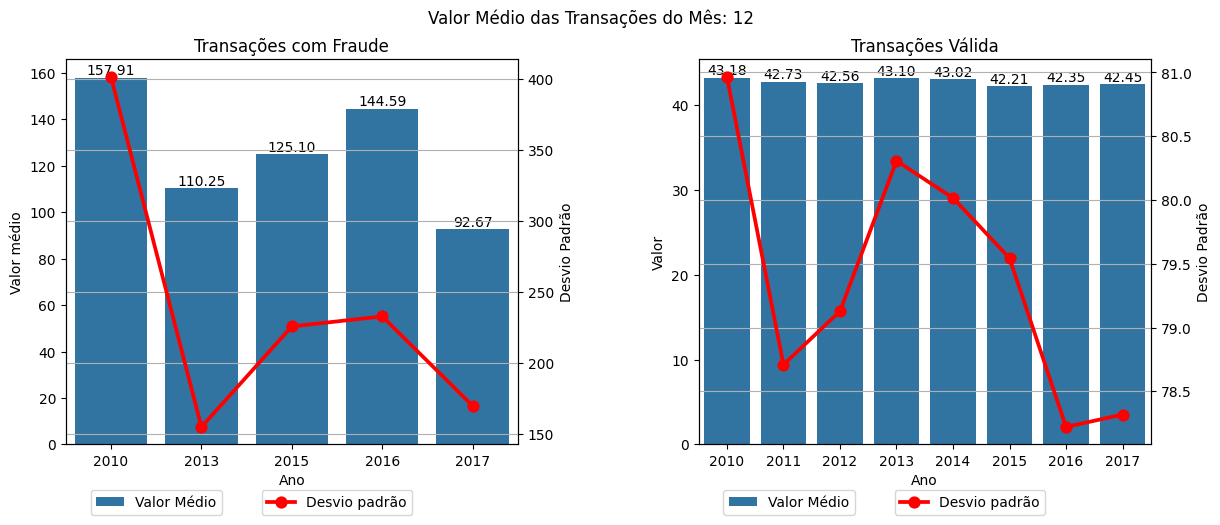

In [21]:
for month in df_time_month['month'].unique():
  df_time_month_month = df_time_month.query('month == @month')

  plt.figure(figsize=(14, 5))

  plt.suptitle(f'Valor Médio das Transações do Mês: {month}')
  plt.subplots_adjust(hspace=0.25, wspace=0.4)

  ax1 = plt.subplot(121)
  plt.title(f'Transações com Fraude')
  ax1 = sns.barplot(data=df_time_month_month.query('target == "Yes"'), x='year', y='mean', ax=ax1, label='Valor Médio')
  ax1.set_ylabel('Valor médio')
  ax1.set_xlabel('Ano')
  ax1.tick_params(axis='y')

  for patches in ax1.patches:
      ax1.annotate(f'{patches.get_height():.2f}', (patches.get_x() + patches.get_width() / 2., patches.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

  ax2 = ax1.twinx()
  ax2 = sns.pointplot(data=df_time_month_month.query('target == "Yes"'), x='year', y='std', ax=ax2, color='red', label='Desvio padrão')

  ax2.set_ylabel('Desvio Padrão')

  ax1.set_zorder(0)
  ax1.patch.set_visible(False)

  plt.grid(True)
  ax1.legend(loc='upper center', bbox_to_anchor=(0.2, -0.10))
  ax2.legend(loc='upper center', bbox_to_anchor=(0.6, -0.10))

  ax3 = plt.subplot(122)
  ax3.set_title('Transações Válida')
  ax3 = sns.barplot(data=df_time_month_month.query('target == "No"'), x='year', y='mean', ax=ax3, label='Valor Médio')

  for patches in ax3.patches:
    ax3.annotate(f'{patches.get_height():.2f}', (patches.get_x() + patches.get_width() / 2., patches.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

  ax3.set_ylabel('Valor')
  ax3.set_xlabel('Ano')

  ax4 = ax3.twinx()
  ax4 = sns.pointplot(data=df_time_month_month.query('target == "No"'), x='year', y='std', ax=ax4, color='red', label='Desvio padrão')

  ax4.set_ylabel('Desvio Padrão')

  ax3.set_zorder(0)
  ax3.patch.set_visible(False)

  ax3.legend(loc='upper center', bbox_to_anchor=(0.2, -0.10))
  ax4.legend(loc='upper center', bbox_to_anchor=(0.6, -0.10))
  plt.grid(True)

plt.show()

### Análise numérica

In [22]:
number_columns = df.select_dtypes(include=['float64', 'int64']).columns
number_columns

Index(['amount', 'current_age', 'retirement_age', 'latitude', 'longitude',
       'per_capita_income', 'yearly_income', 'total_debt', 'credit_score',
       'num_credit_cards', 'num_cards_issued', 'credit_limit',
       'year_pin_last_changed'],
      dtype='object')

In [23]:
df[number_columns].describe()

amount   current_age  retirement_age      latitude     longitude  \
count  7.405370e+06  7.405370e+06    7.405370e+06  7.405370e+06  7.405370e+06   
mean   4.300867e+01  5.409568e+01    6.648482e+01  3.737115e+01 -9.156545e+01   
std    8.166883e+01  1.569480e+01    3.588236e+00  5.097716e+00  1.625642e+01   
min   -5.000000e+02  2.300000e+01    5.300000e+01  2.130000e+01 -1.581800e+02   
25%    8.940000e+00  4.200000e+01    6.500000e+01  3.389000e+01 -9.737000e+01   
50%    2.903000e+01  5.200000e+01    6.600000e+01  3.835000e+01 -8.647000e+01   
75%    6.384000e+01  6.300000e+01    6.800000e+01  4.112000e+01 -8.013000e+01   
max    5.696780e+03  1.010000e+02    7.900000e+01  4.853000e+01 -6.867000e+01   

       per_capita_income  yearly_income    total_debt  credit_score  \
count       7.405370e+06   7.405370e+06  7.405370e+06  7.405370e+06   
mean        2.398496e+04   4.668939e+04  5.796217e+04  7.138754e+02   
std         1.197932e+04   2.446512e+04  5.201771e+04  6.581421e+01   
min         0.000000e+00   1.000000e+00  0.000000e+00  4.880000e+02   
25%         1.711300e+04   3.281700e+04  1.643700e+04  6.840000e+02   
50%         2.115900e+04   4.106900e+04  5.167900e+04  7.160000e+02   
75%         2.730800e+04   5.399600e+04  8.516000e+04  7.560000e+02   
max         1.631450e+05   2.801990e+05  4.618540e+05  8.500000e+02   

       num_credit_cards  num_cards_issued  credit_limit  year_pin_last_changed  
count      7.405370e+06      7.405370e+06  7.405370e+06           7.405370e+06  
mean       3.842856e+00      1.521537e+00  1.552508e+04           2.011252e+03  
std        1.568051e+00      5.149337e-01  1.218646e+04           2.854387e+00  
min        1.000000e+00      1.000000e+00  0.000000e+00           2.002000e+03  
25%        3.000000e+00      1.000000e+00  8.081000e+03           2.009000e+03  
50%        4.000000e+00      2.000000e+00  1.343800e+04           2.011000e+03  
75%        5.000000e+00      2.000000e+00  2.083800e+04           2.013000e+03  
max        9.000000e+00      3.000000e+00  1.413910e+05           2.020000e+03

In [24]:
def plot_hist_box(df_, var):
  data = df[var]

  fig = plt.figure(figsize=(15,4))
  ax1 = fig.add_subplot(1, 3, 1)
  ax1.set_title('Histograma')
  sns.histplot(data, kde=True, ax = ax1)
  ax1.set_xlabel(var)
  ax1.tick_params(axis='x', rotation=90)
  ax1.set_ylabel('Frequência')

  ax2 = fig.add_subplot(1, 3, 2)
  ax2.set_title('Boxplot')
  sns.boxplot(data, ax=ax2)
  ax2.set_ylabel('Frequência')

  ax3 = fig.add_subplot(1, 3, 3)
  ax3.set_title('QQ-plot')
  sm.qqplot(data, line='s', ax=ax3)

  plt.suptitle(f'{var}')
  plt.tight_layout()
  plt.show()

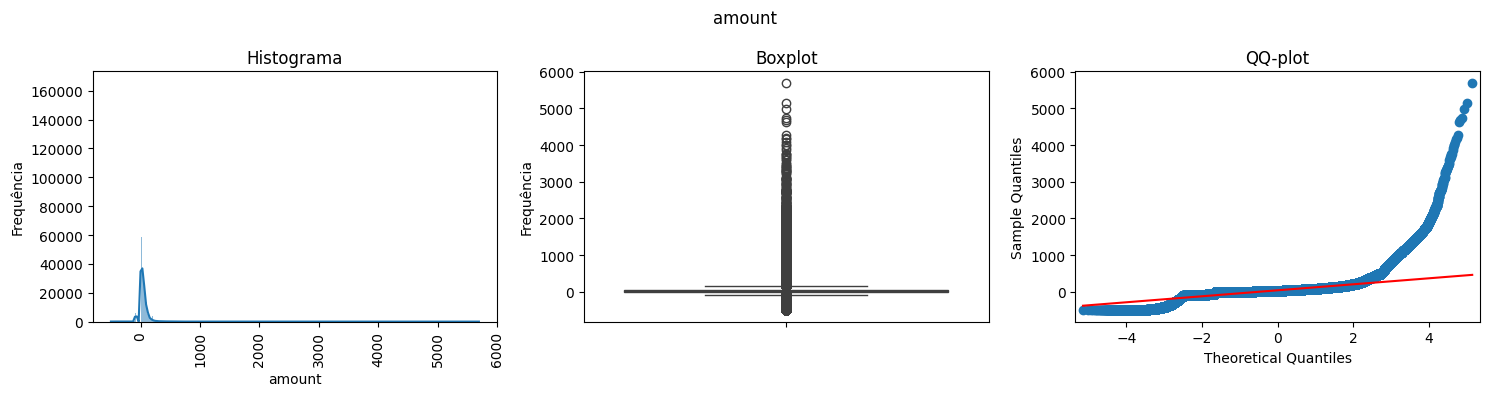

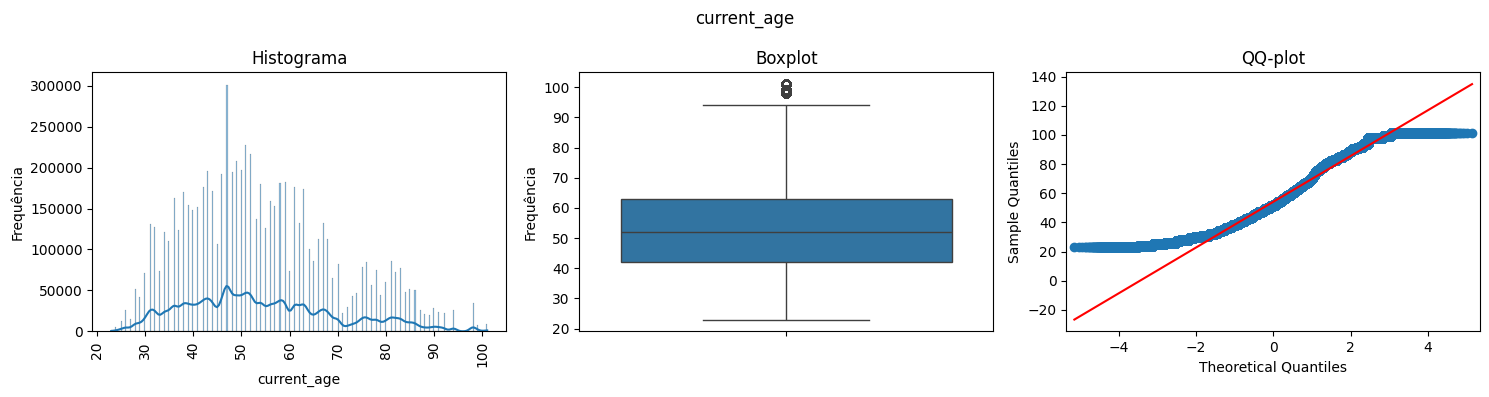

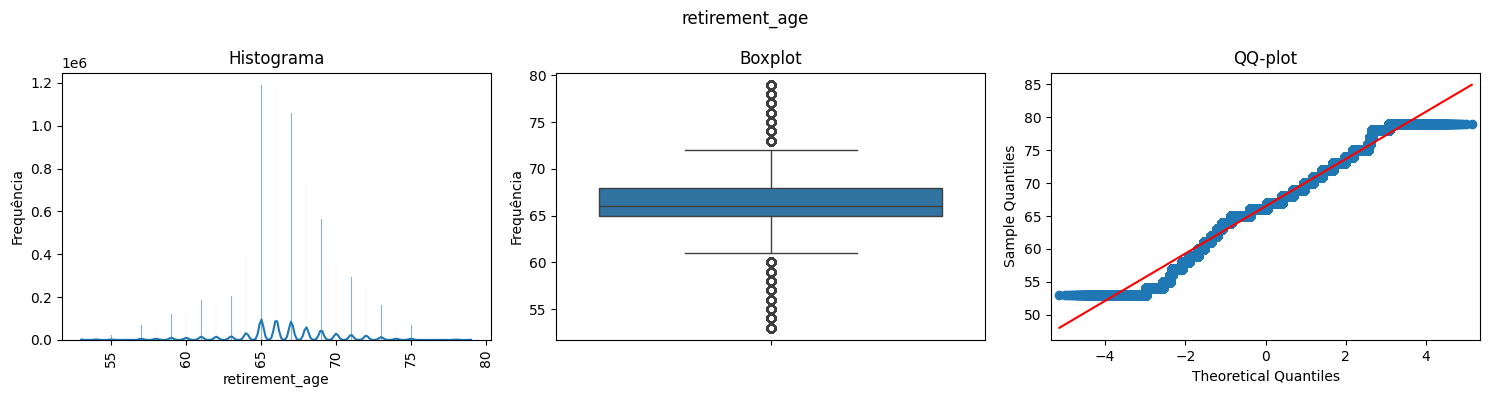

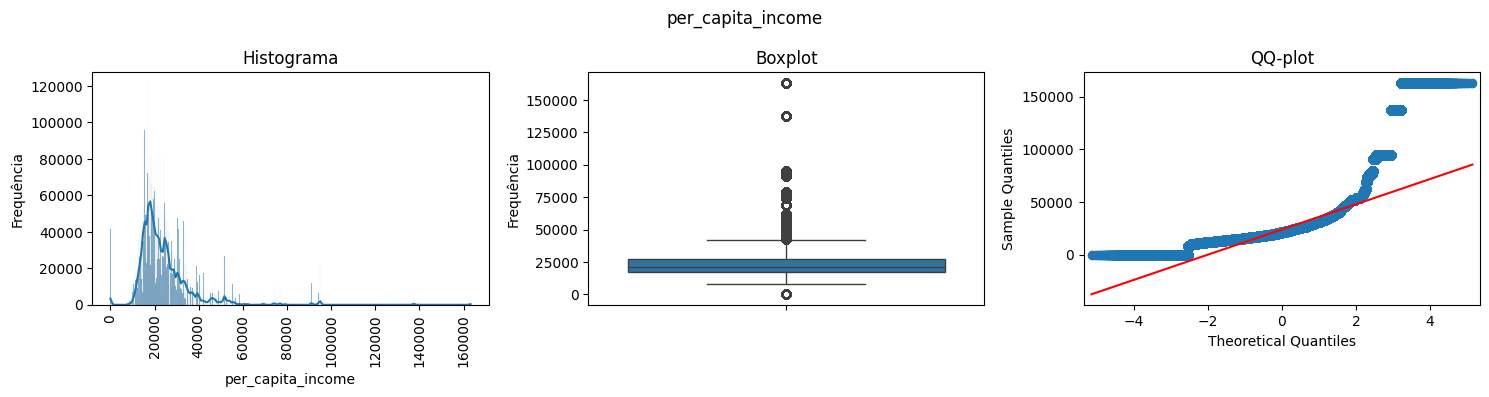

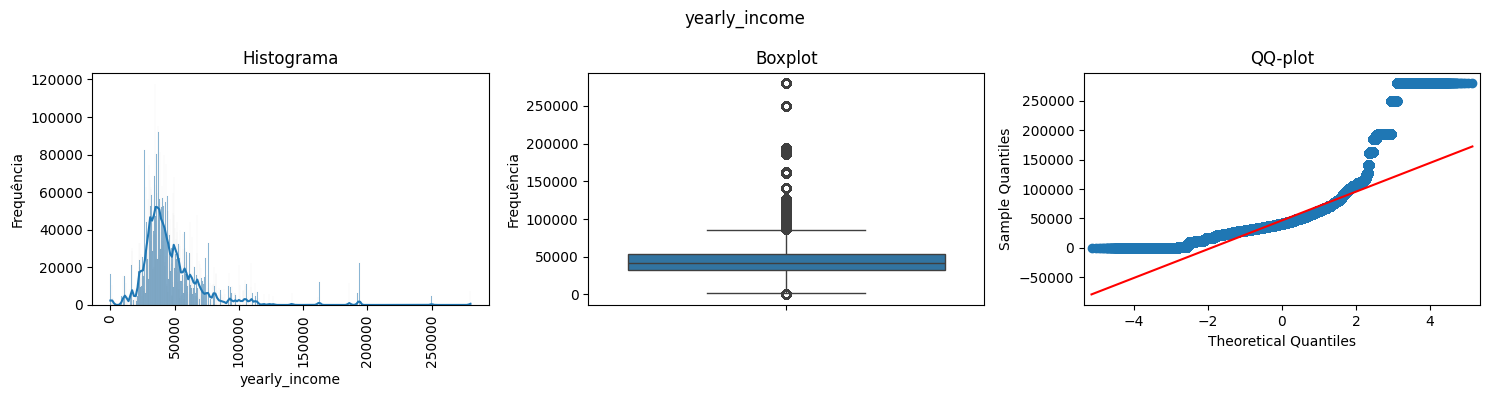

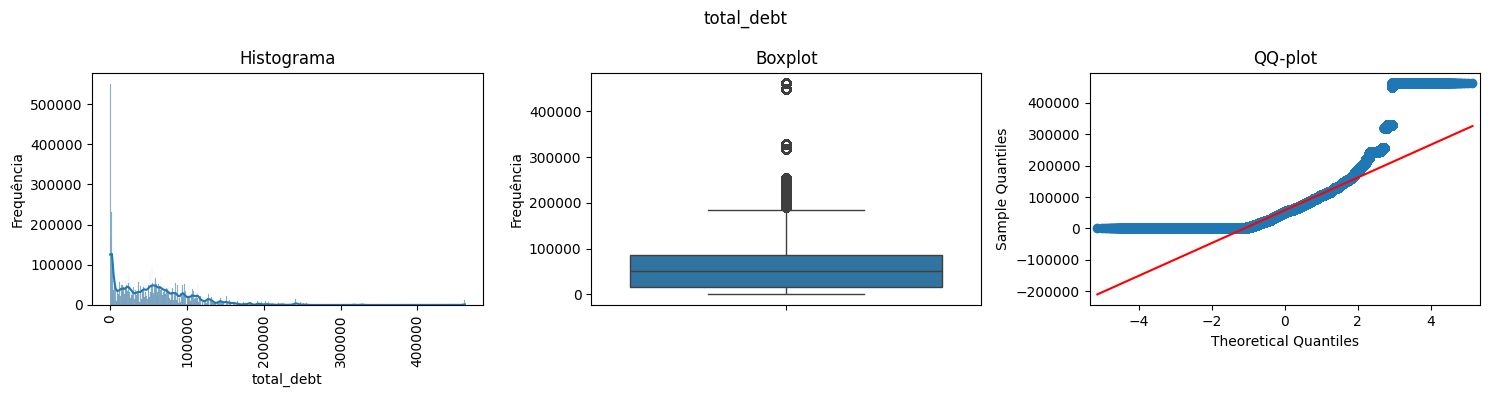

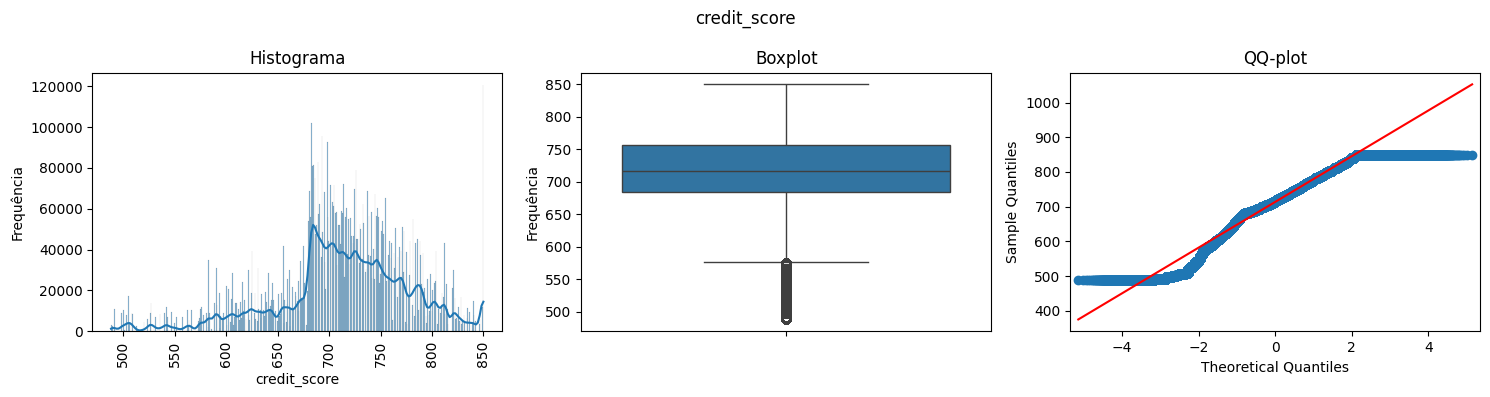

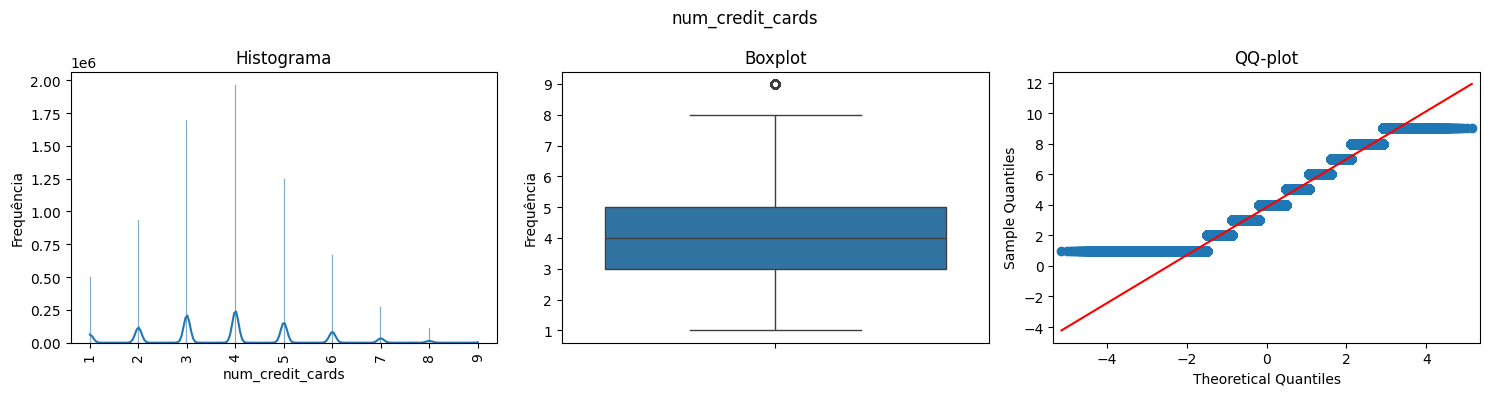

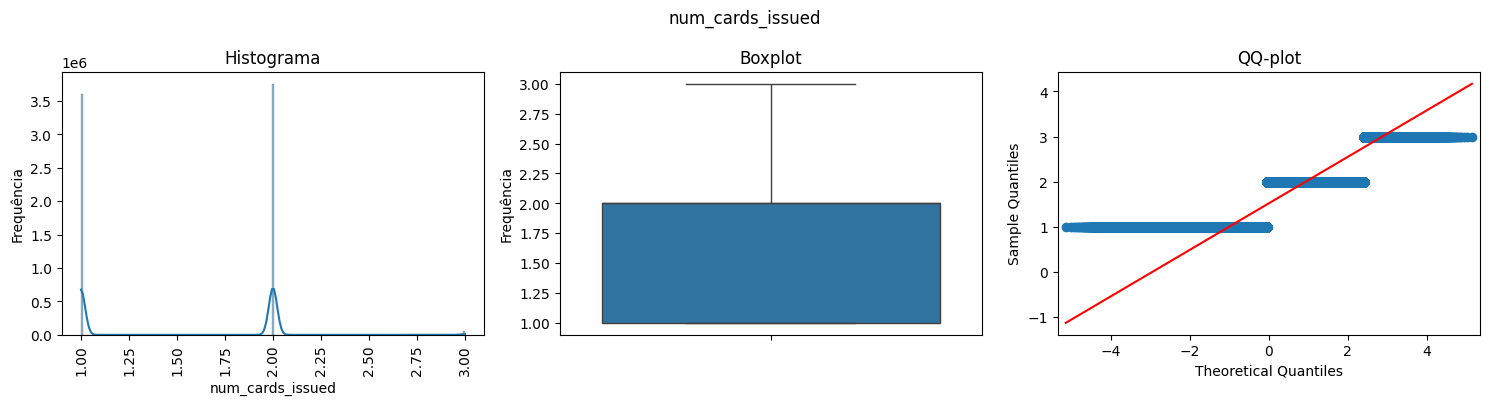

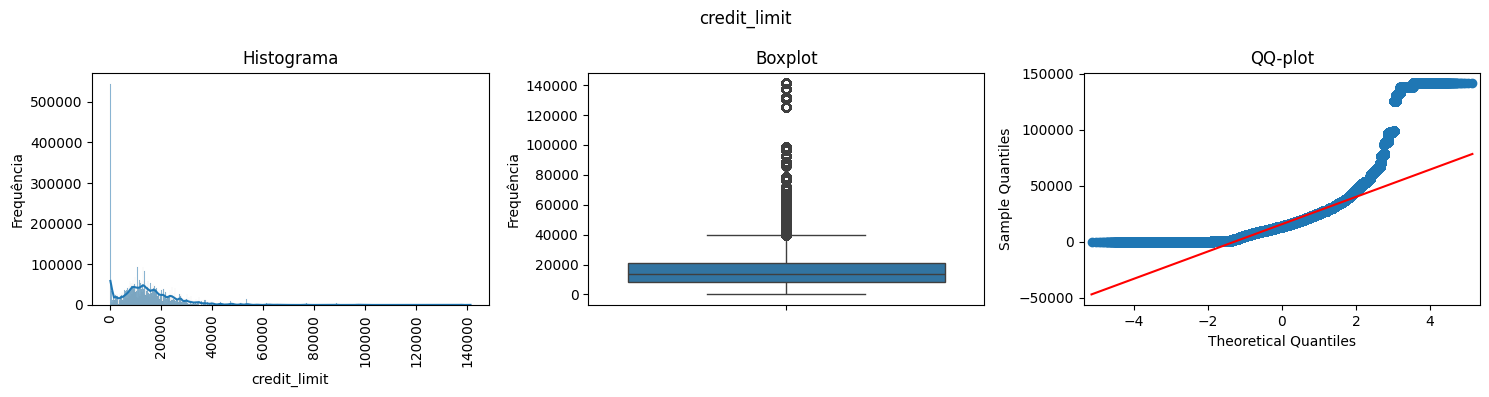

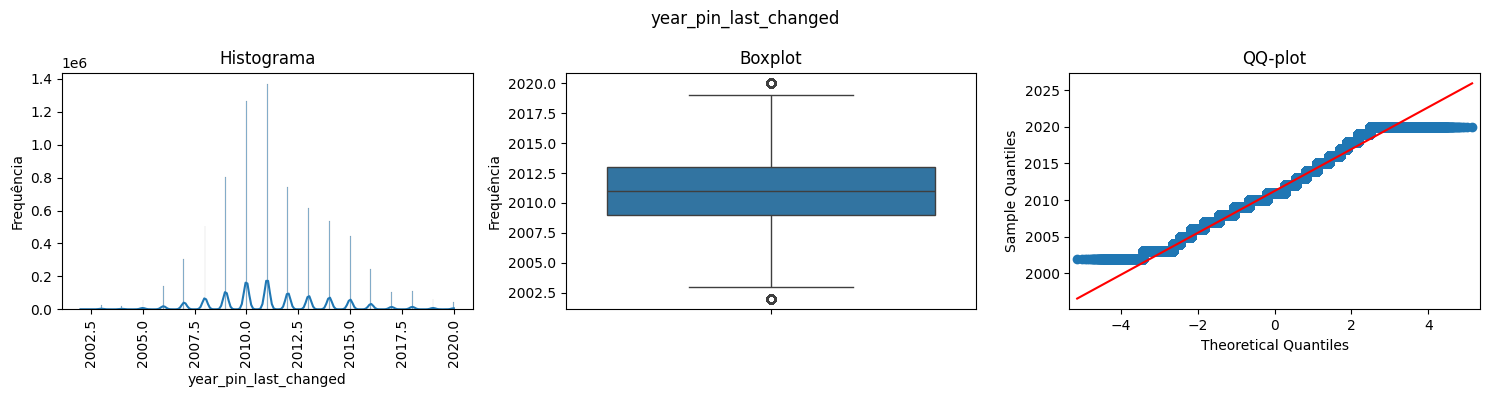

In [25]:
for column in filter(lambda x: x not in ['latitude', 'longitude'], number_columns):
  plot_hist_box(df, column)

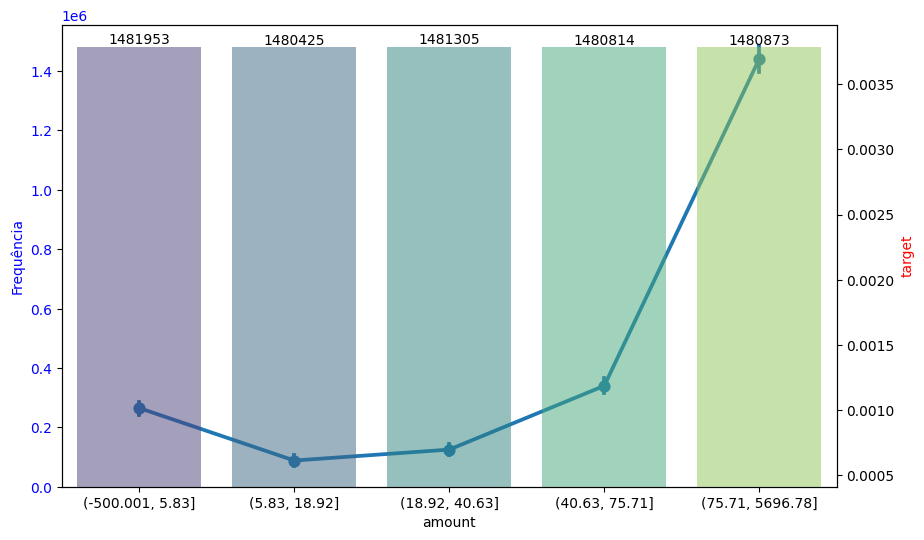

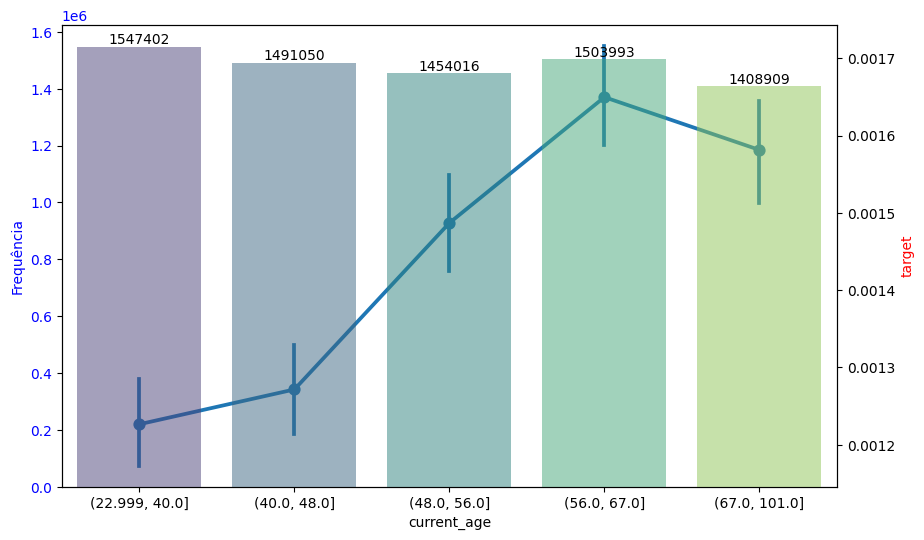

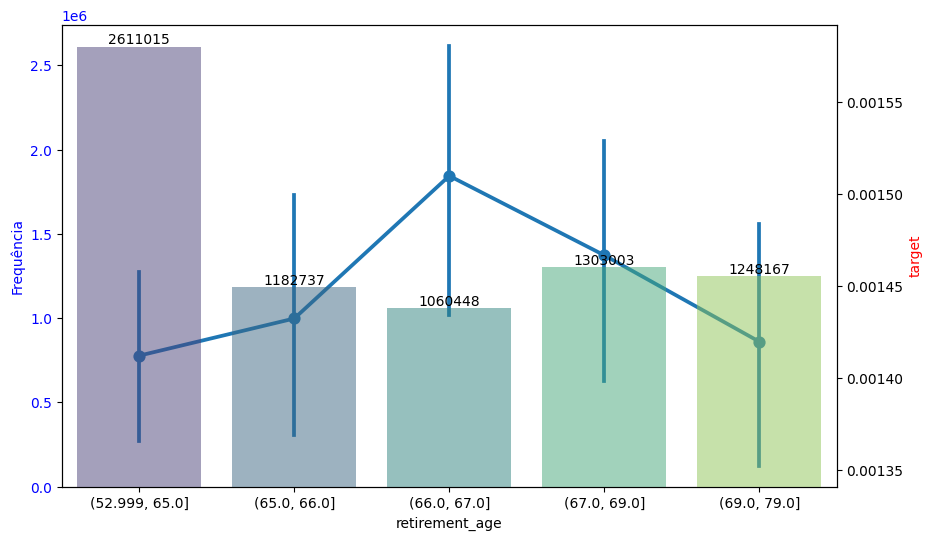

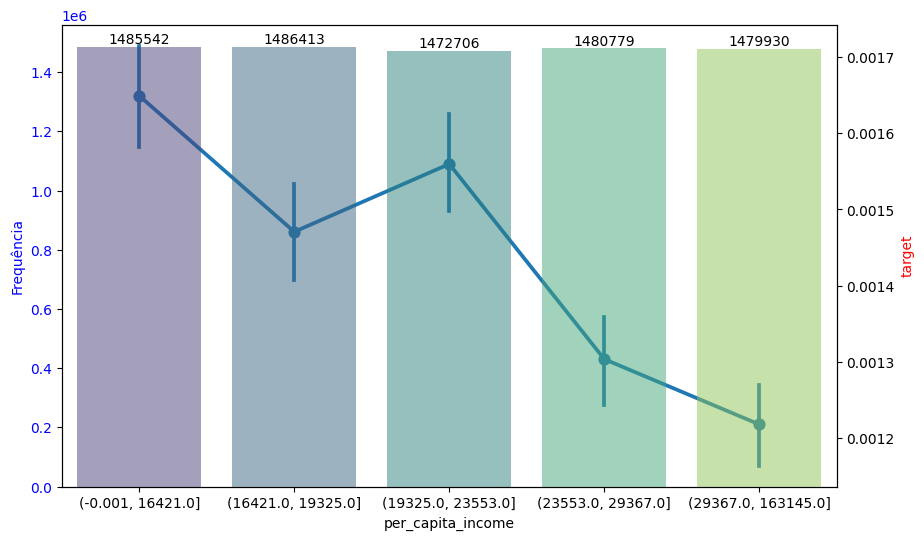

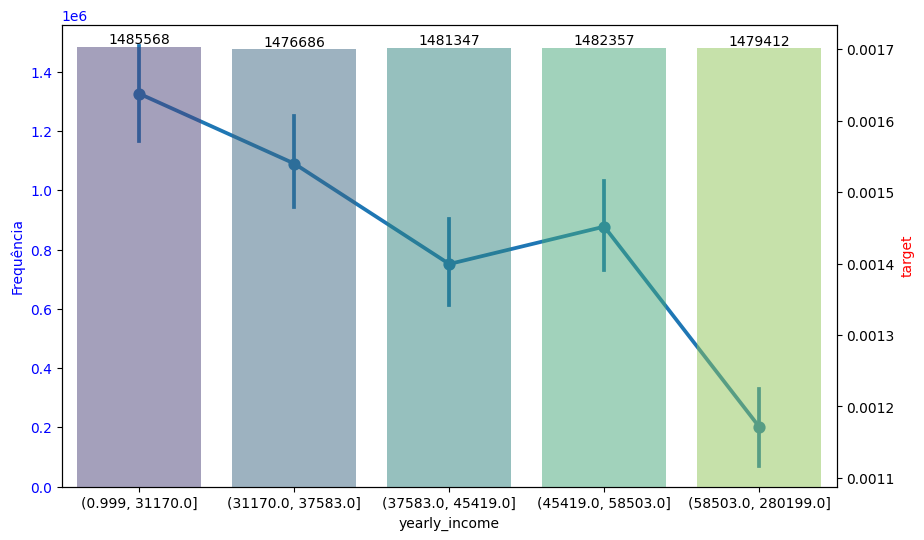

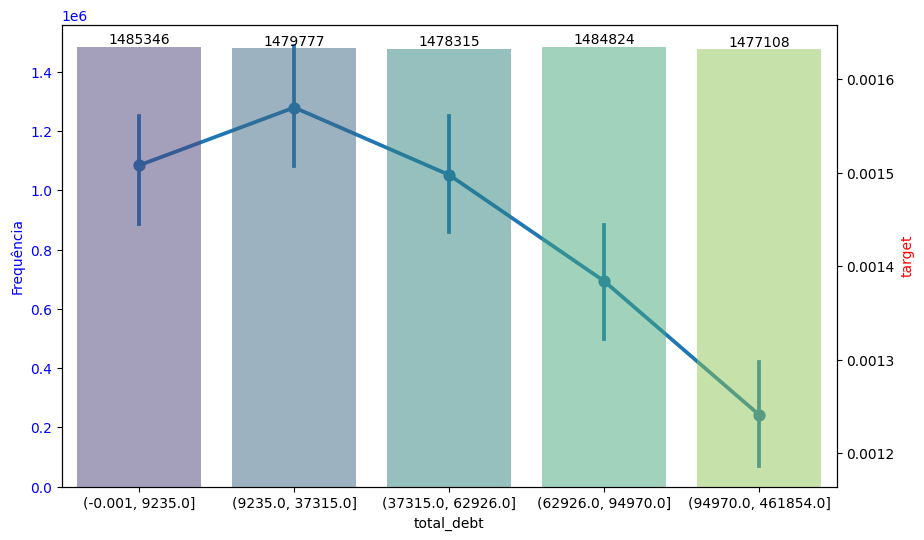

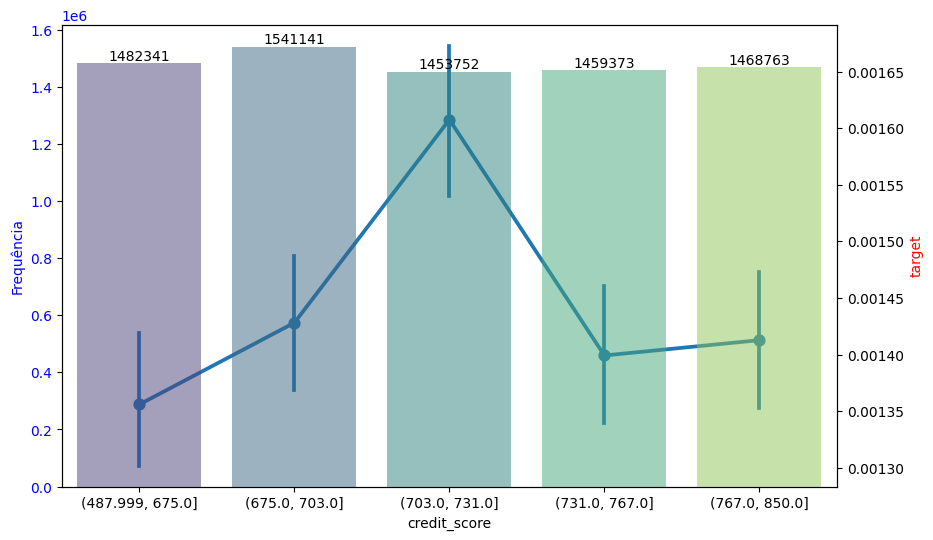

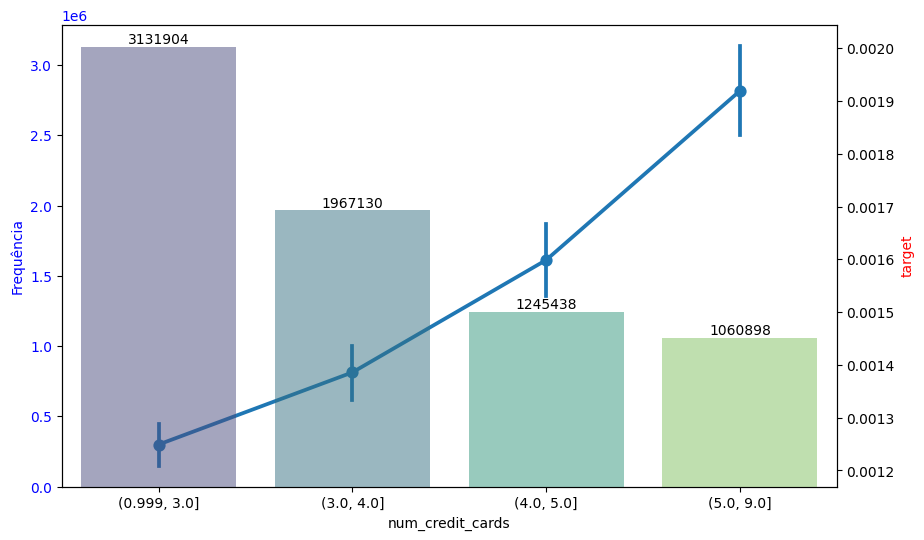

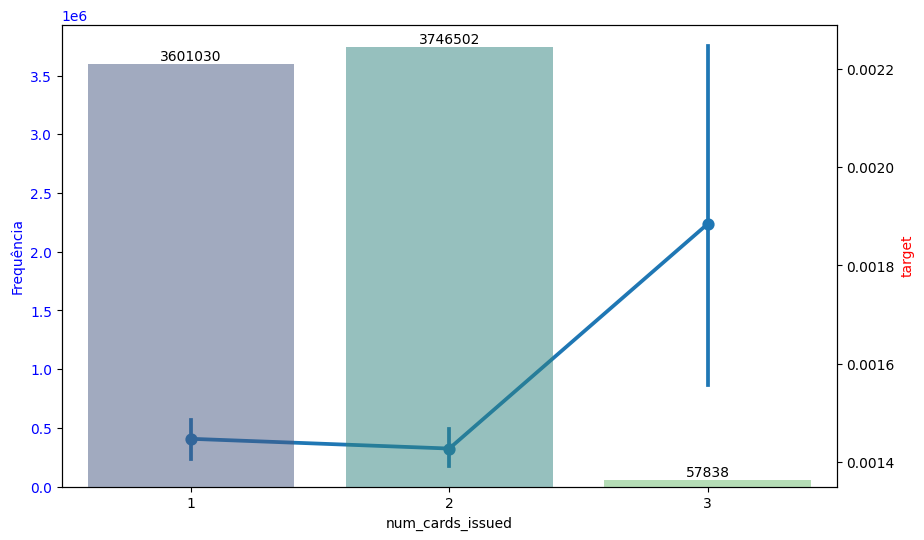

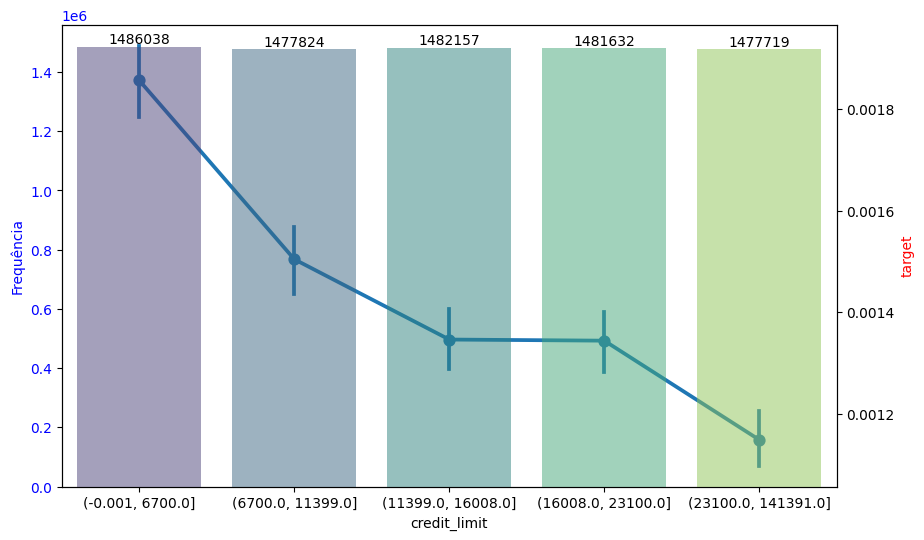

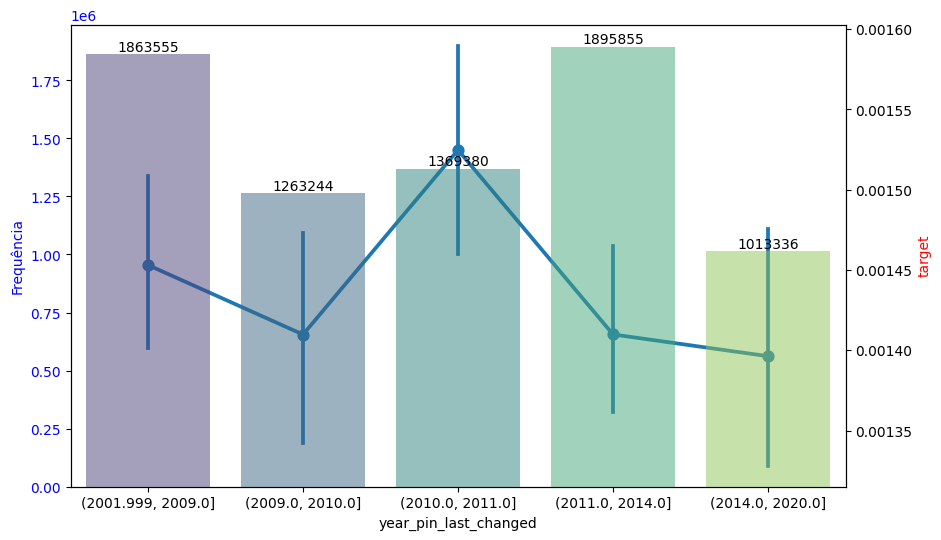

In [26]:
for column in filter(lambda x: x not in ['latitude', 'longitude'], number_columns):
    descritiva(df, column, 'target', map_target={ 'Yes': 1, 'No': 0 })

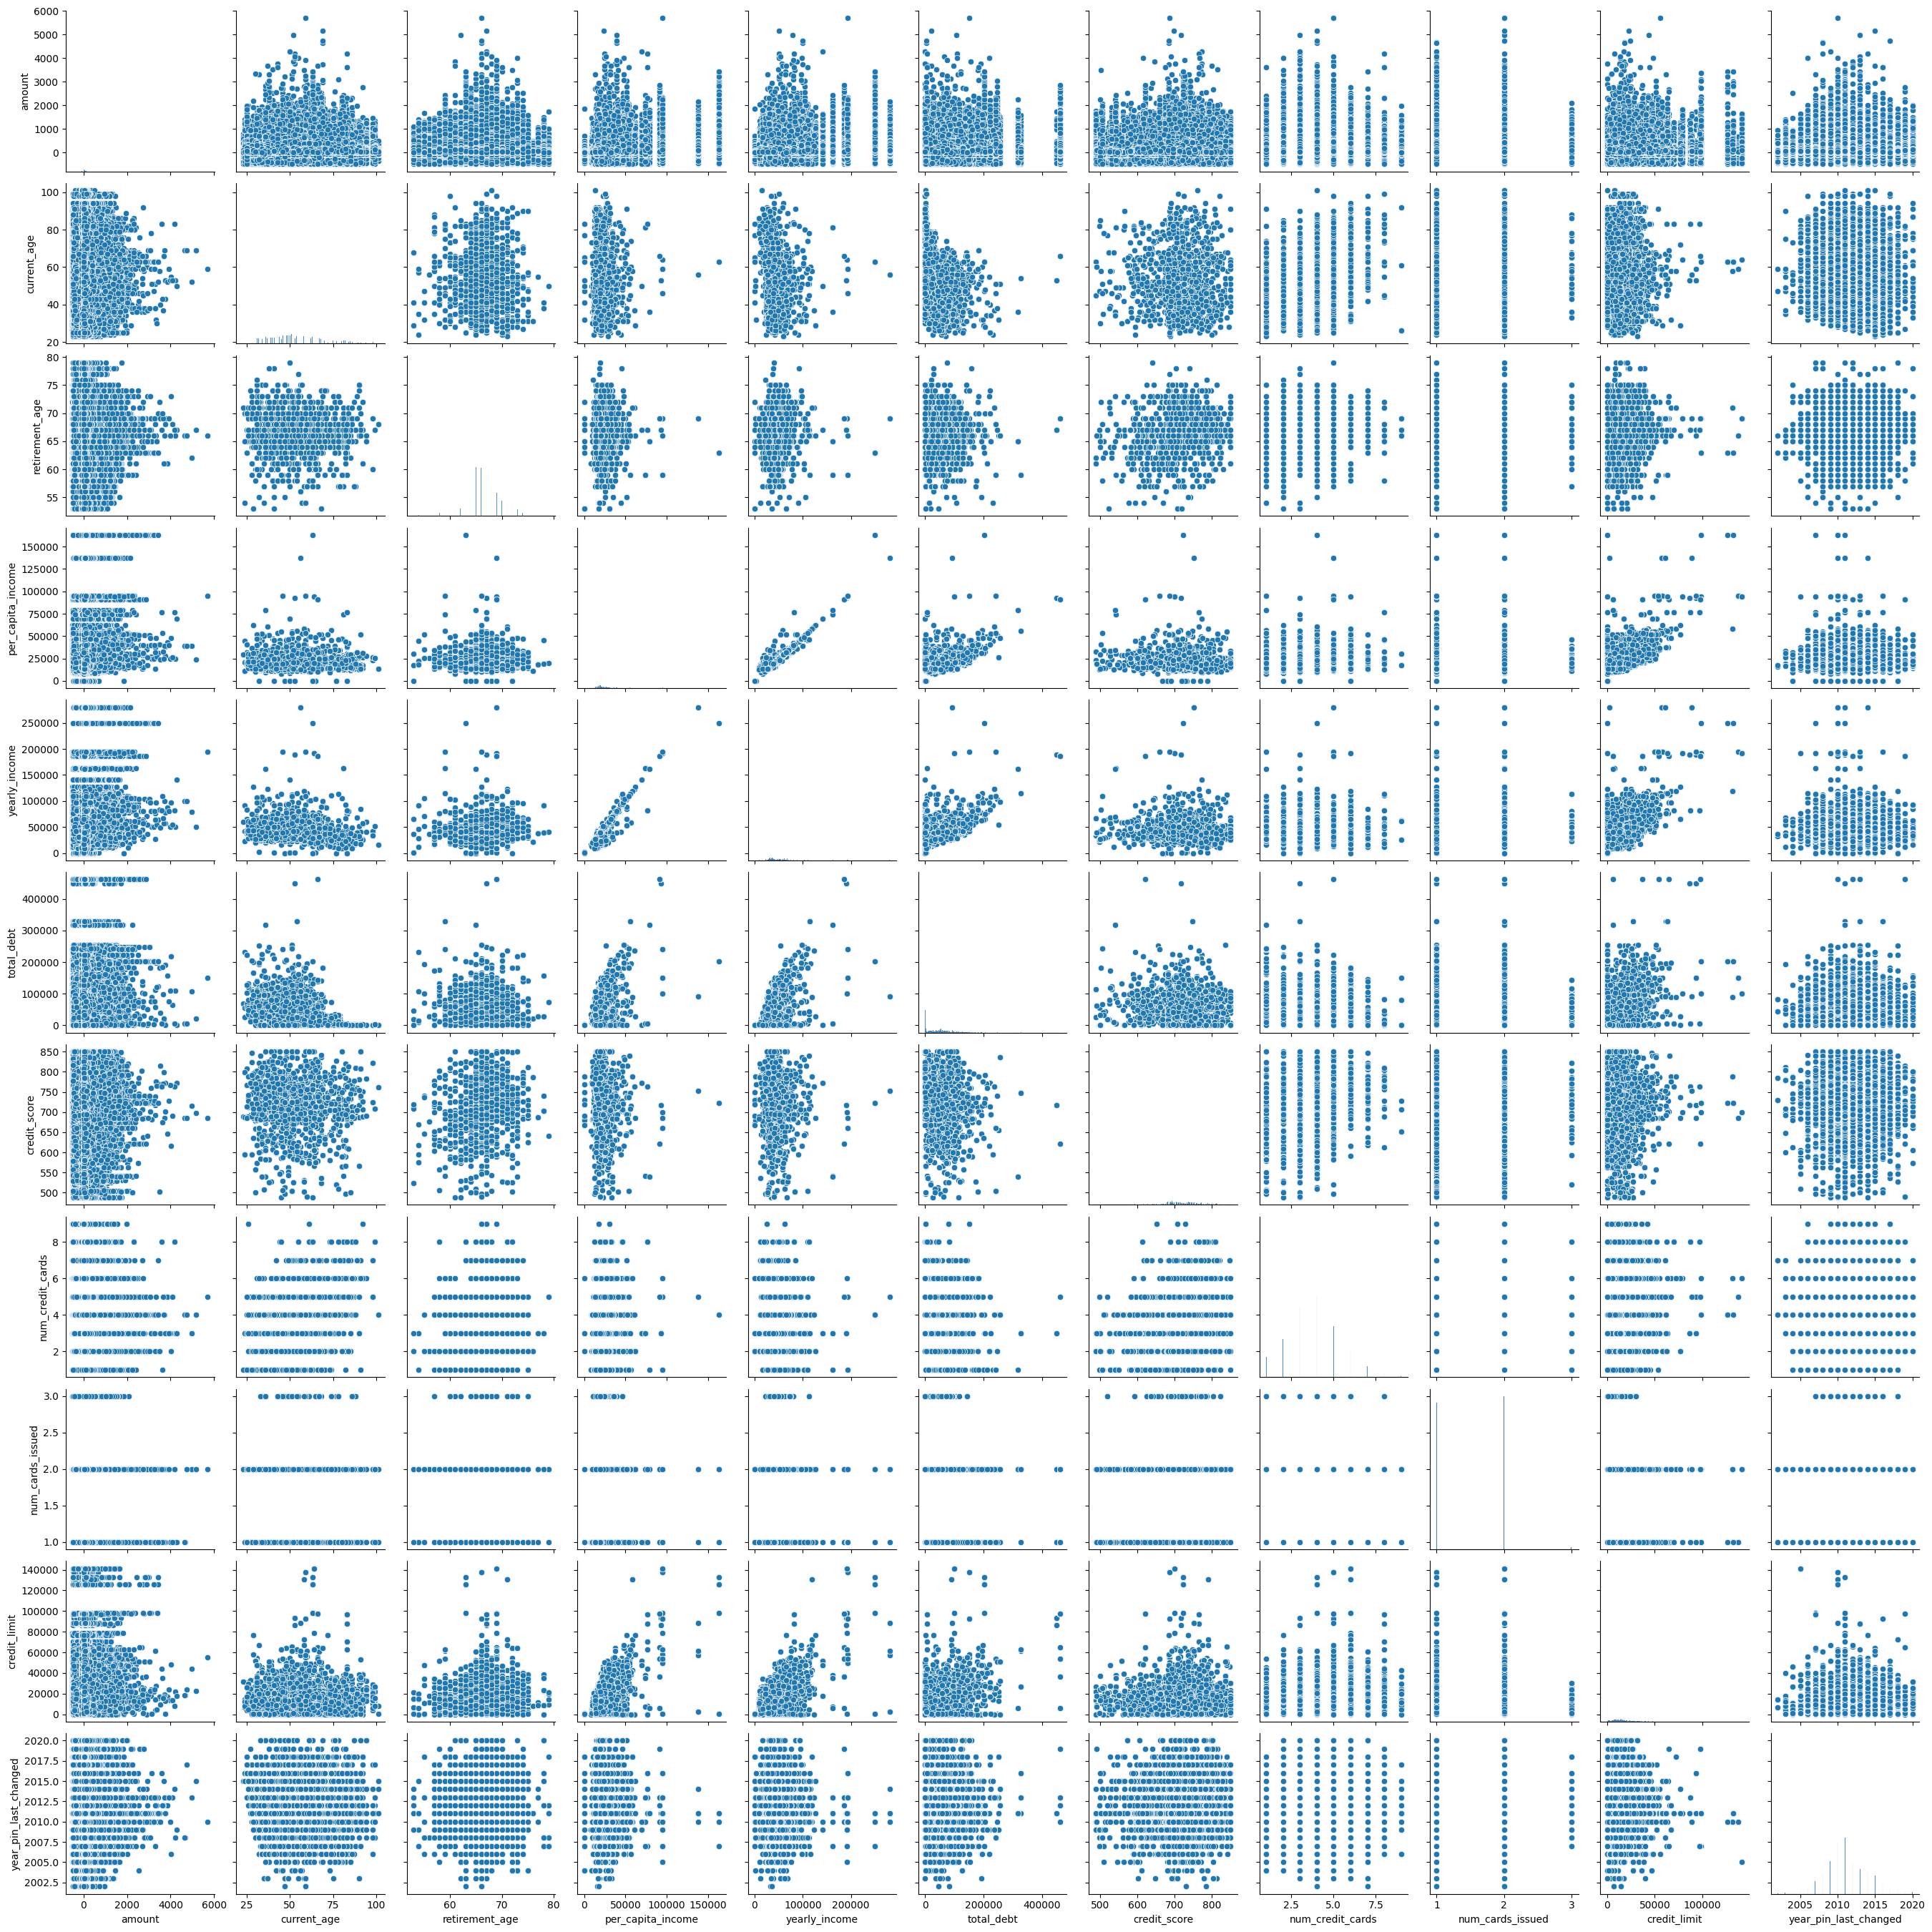

In [27]:
ax = sns.pairplot(df[number_columns].drop(columns=['latitude', 'longitude']))
plt.show()

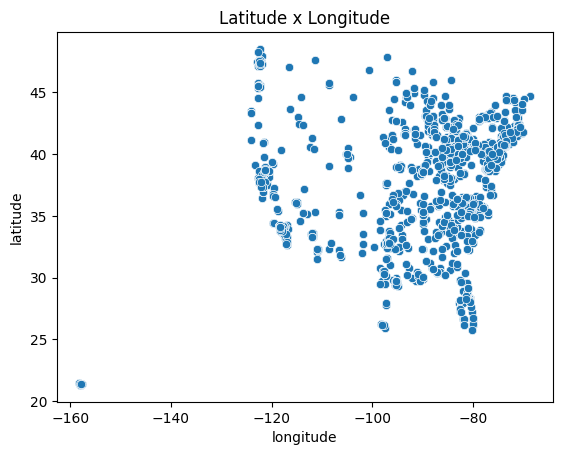

In [28]:
plt.title('Latitude x Longitude')
sns.scatterplot(data=df, x='longitude', y='latitude')
plt.show()

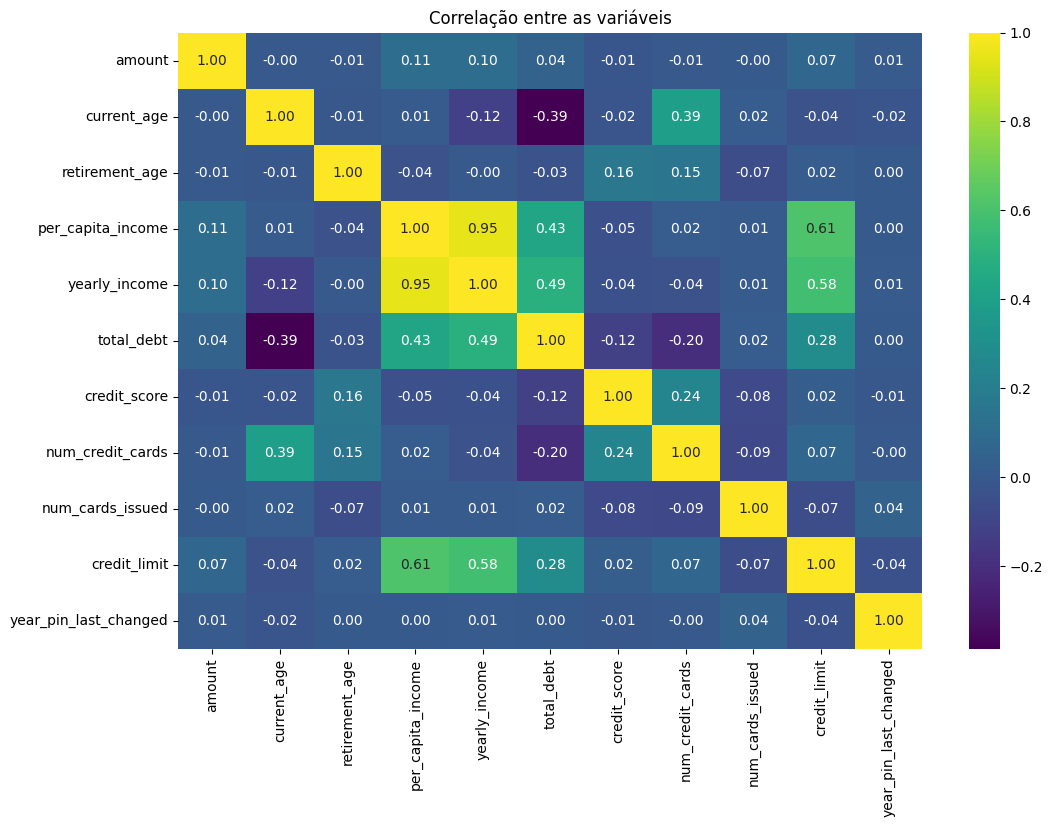

In [29]:
plt.figure(figsize=(12,8))
plt.title('Correlação entre as variáveis')

corr = df[number_columns].drop(columns=['latitude', 'longitude']).corr()
sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()
del corr

## Análise Categorica

In [30]:
categorical_columns = df.drop(columns=['id', 'client_id', 'merchant_id', 'card_id', 'target']).select_dtypes(include=['object']).columns.tolist()
categorical_columns

['use_chip',
 'merchant_city',
 'merchant_state',
 'zip',
 'mcc',
 'errors',
 'description',
 'birth_year',
 'birth_month',
 'gender',
 'address',
 'card_brand',
 'card_type',
 'card_number',
 'expires',
 'cvv',
 'has_chip',
 'acct_open_date',
 'card_on_dark_web']

In [31]:
df[categorical_columns].describe()

use_chip merchant_city merchant_state      zip      mcc  \
count             7405370       7405370        6541016  7405370  7405370   
unique                  3         11846            190    23851      109   
top     Swipe Transaction        ONLINE             CA      nan     5411   
freq              4412725        864354         794465   911945   885927   

                      errors                   description birth_year  \
count                 117765                       7405370    7405370   
unique                    22                           108         74   
top     Insufficient Balance  Grocery Stores, Supermarkets       1972   
freq                   72940                        885927     292996   

       birth_month   gender              address  card_brand card_type  \
count      7405370  7405370              7405370     7405370   7405370   
unique          12        2                 1219           4         3   
top             11   Female  772 Fifth Boulevard  Mastercard     Debit   
freq        757524  3792336                27085     3981769   4601680   

             card_number  expires      cvv has_chip acct_open_date  \
count            7405370  7405370  7405370  7405370        7405370   
unique              3976      180      983        2            277   
top     5412731781518758  02/2020      265      YES        02/2010   
freq               20448   251016    33858  6664453         138849   

       card_on_dark_web  
count           7405370  
unique                1  
top                  No  
freq            7405370

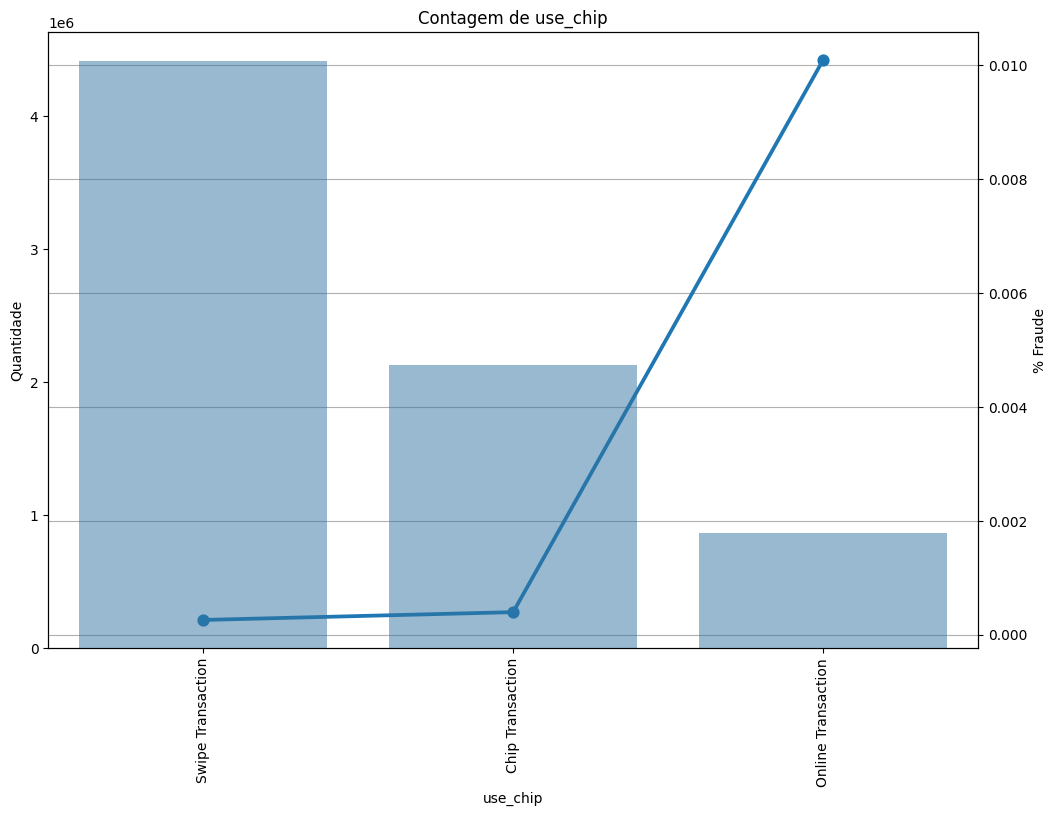

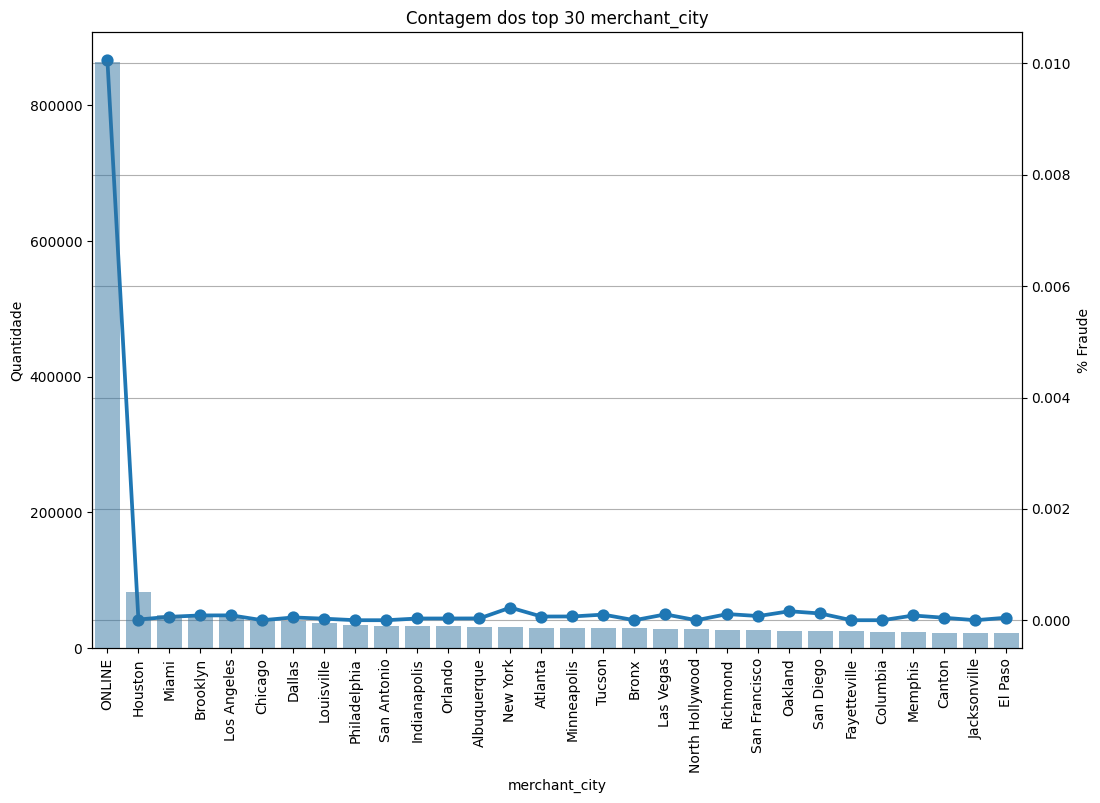

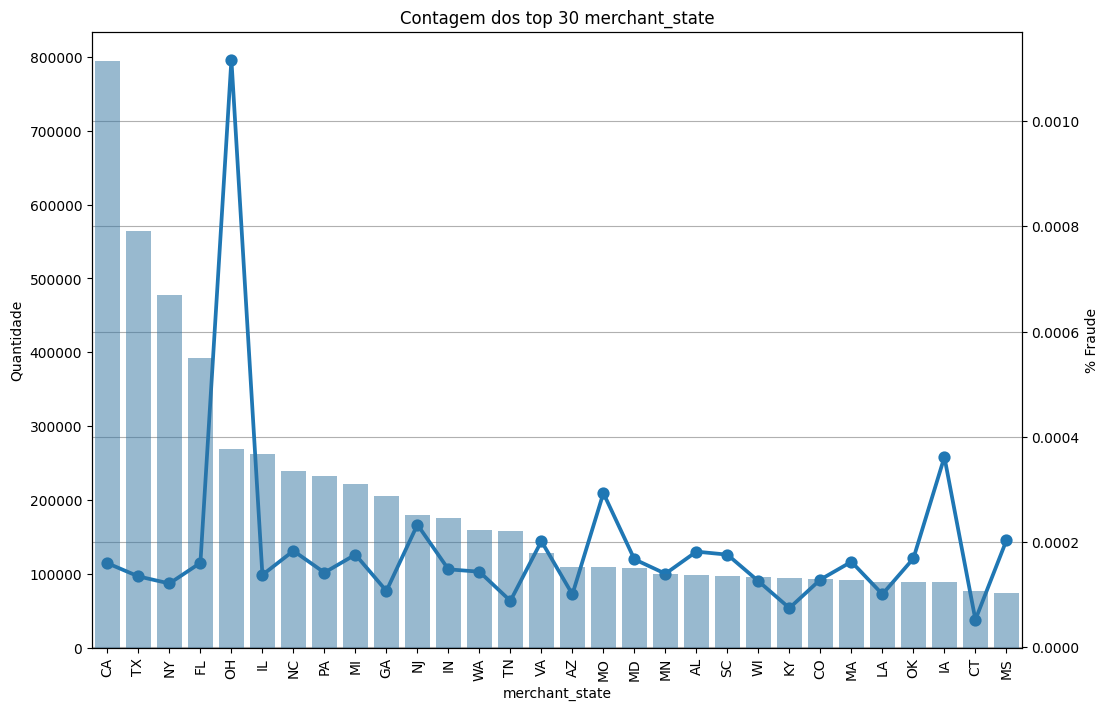

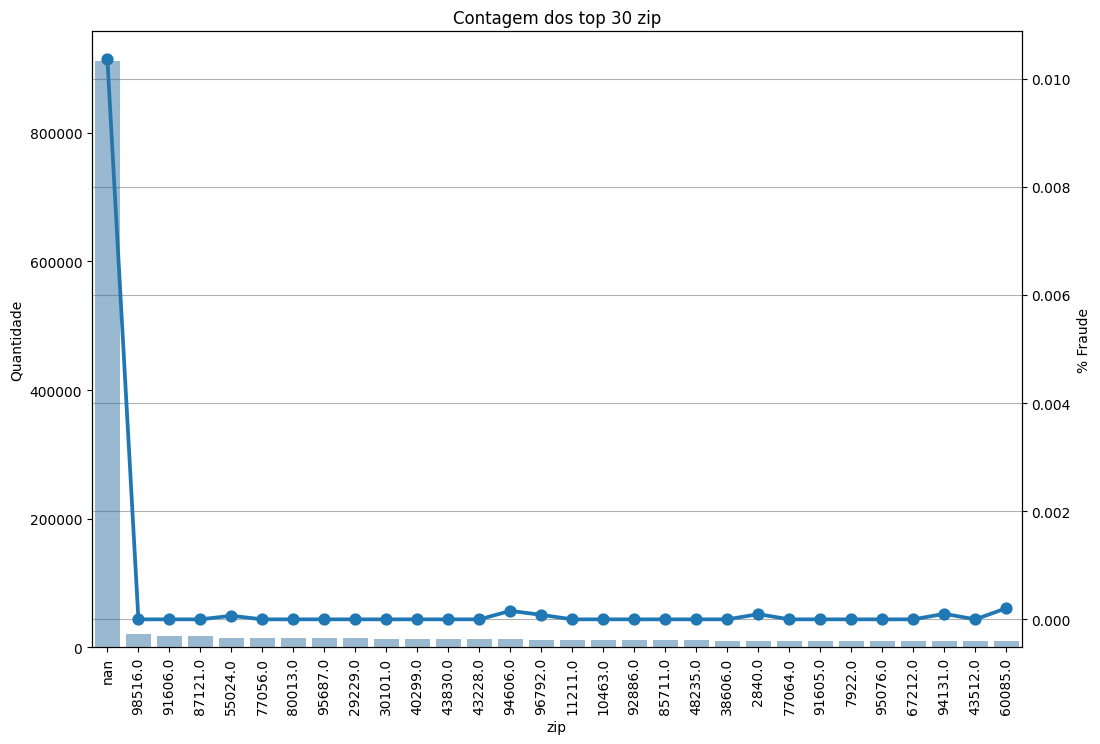

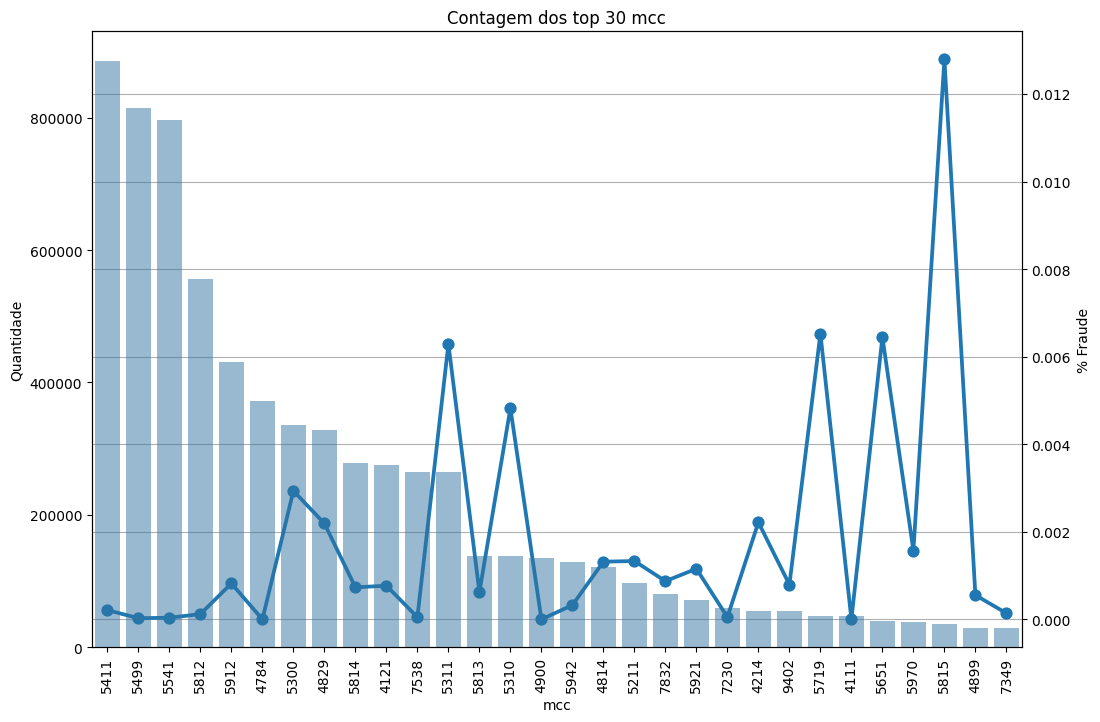

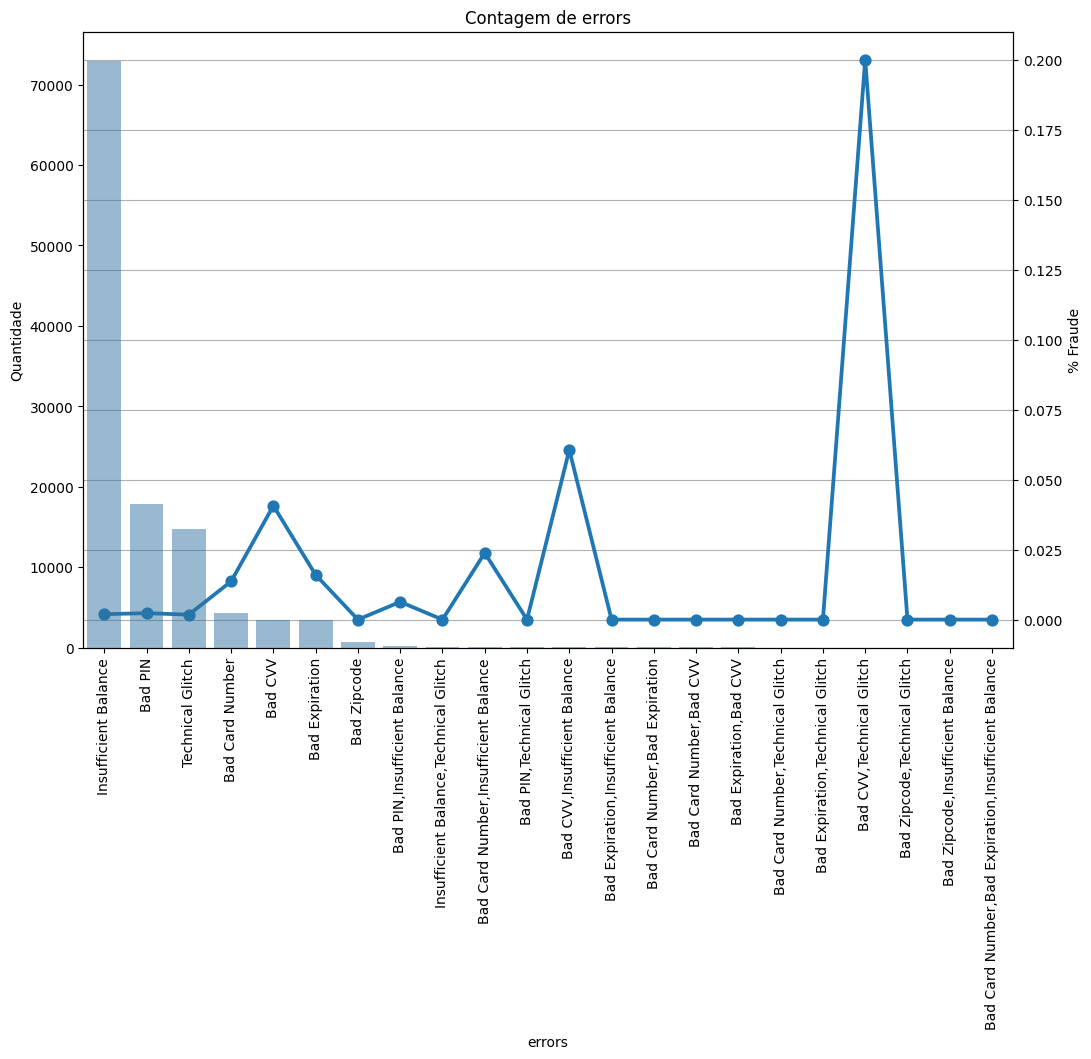

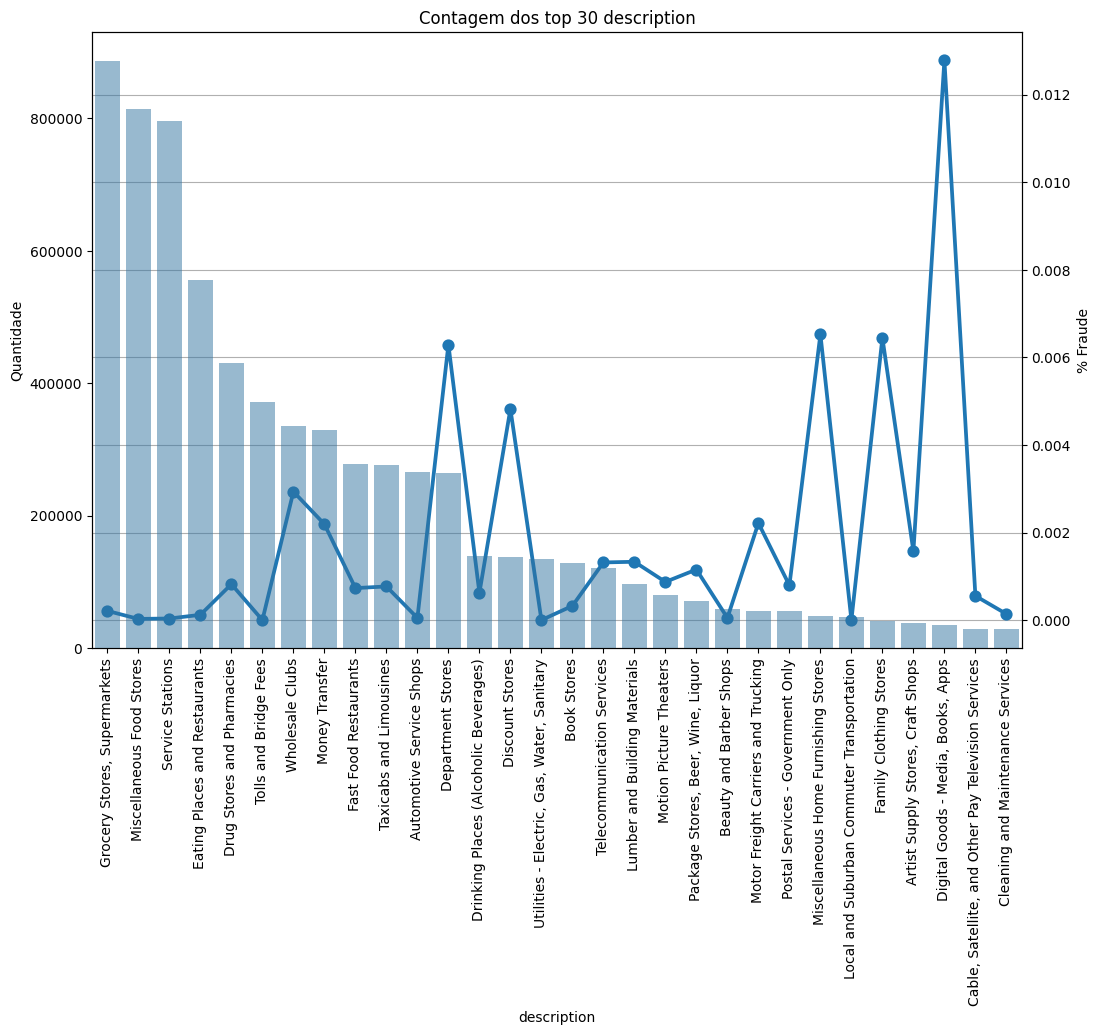

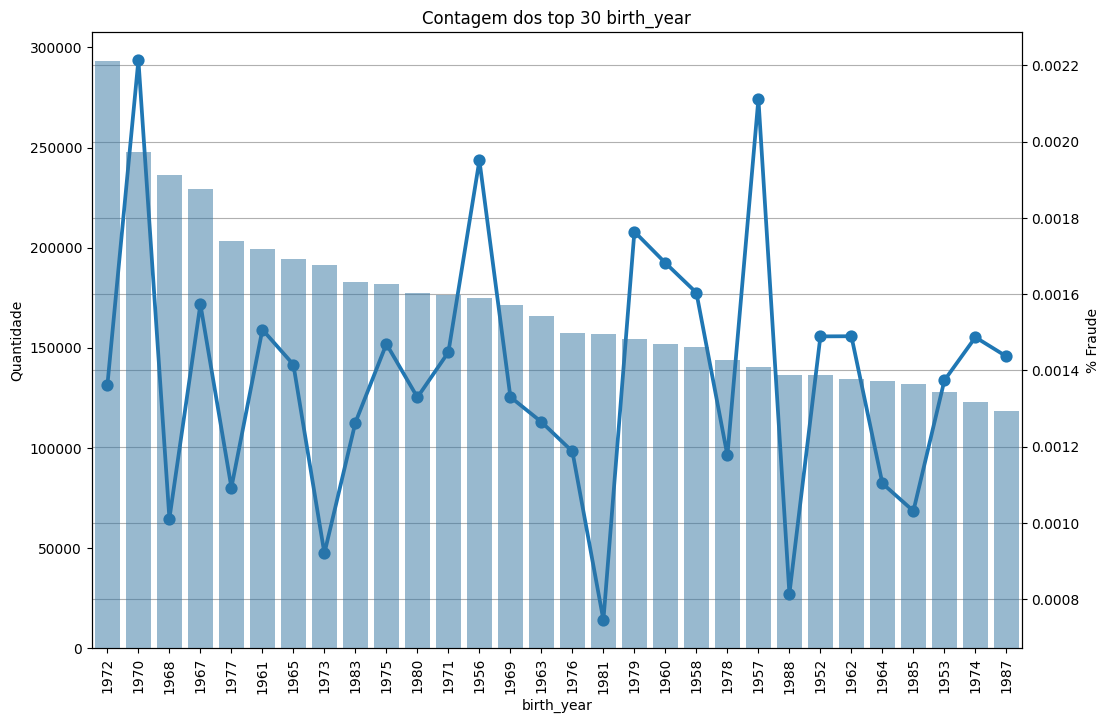

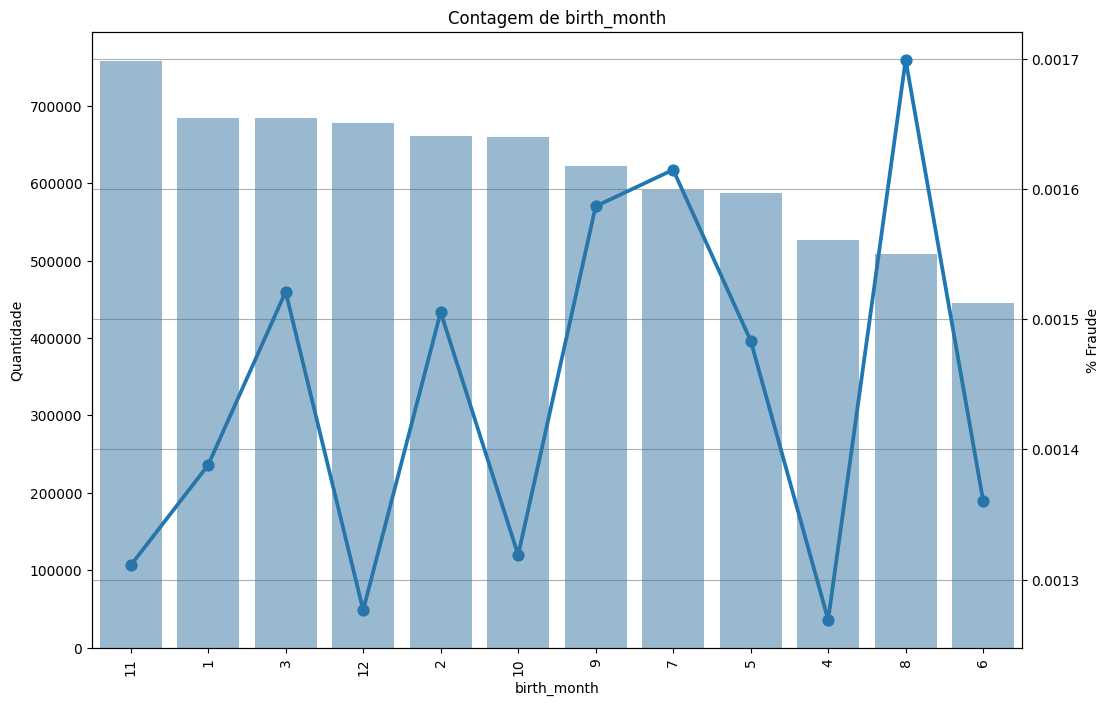

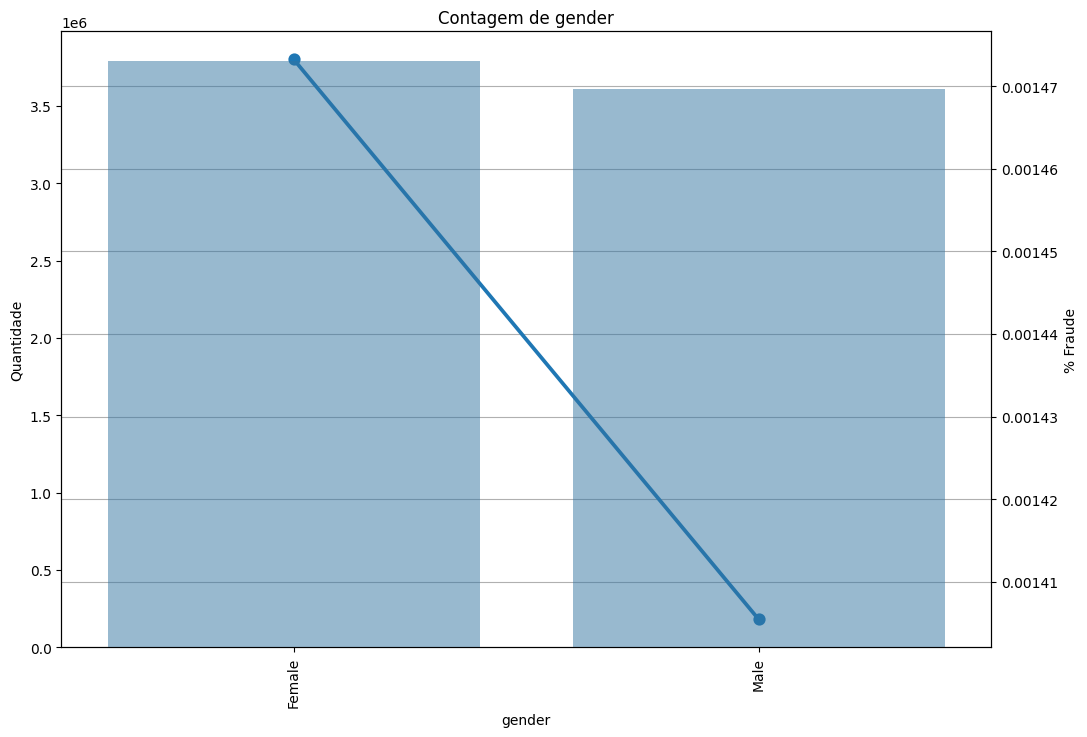

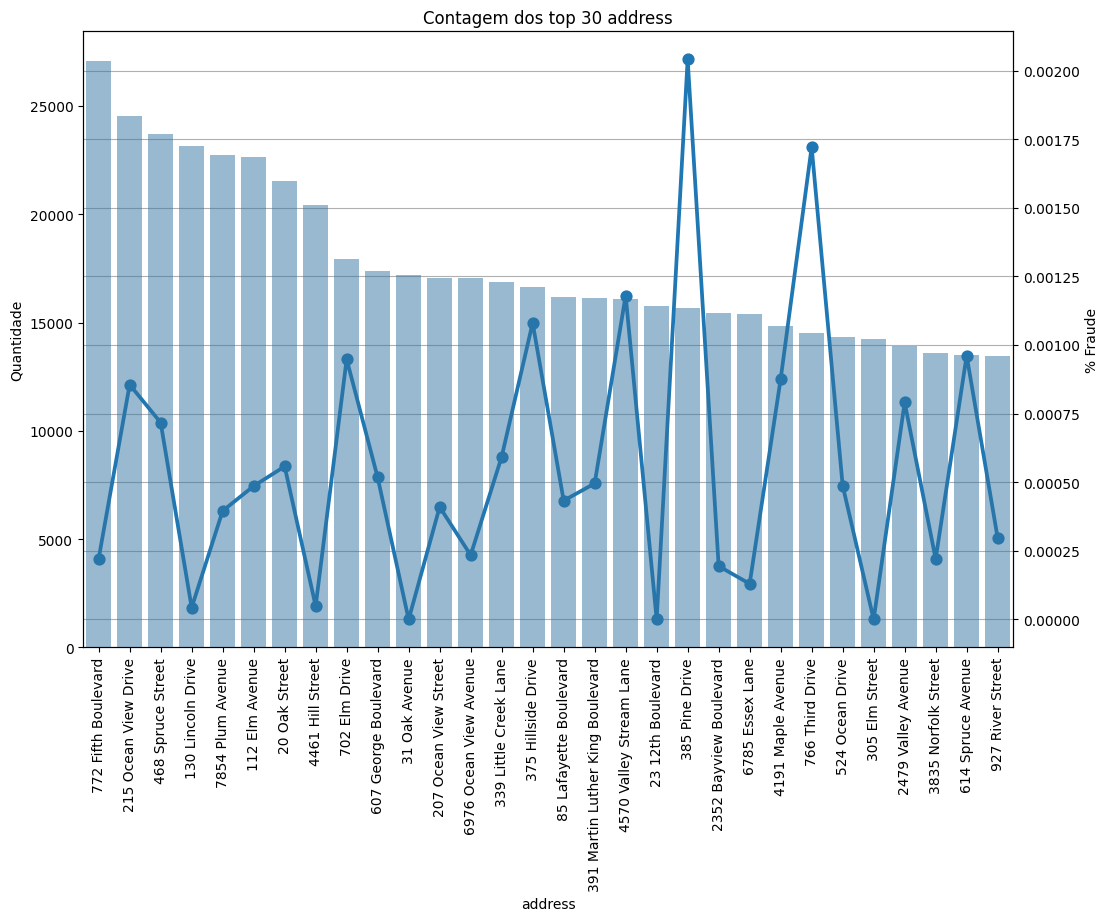

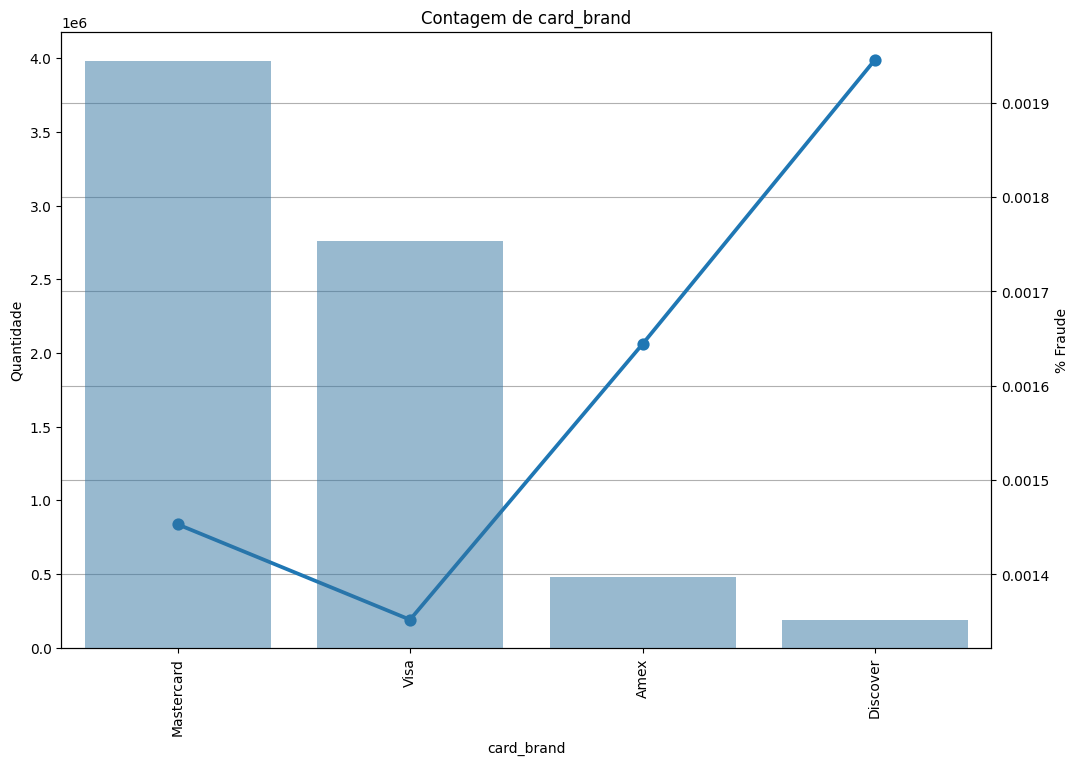

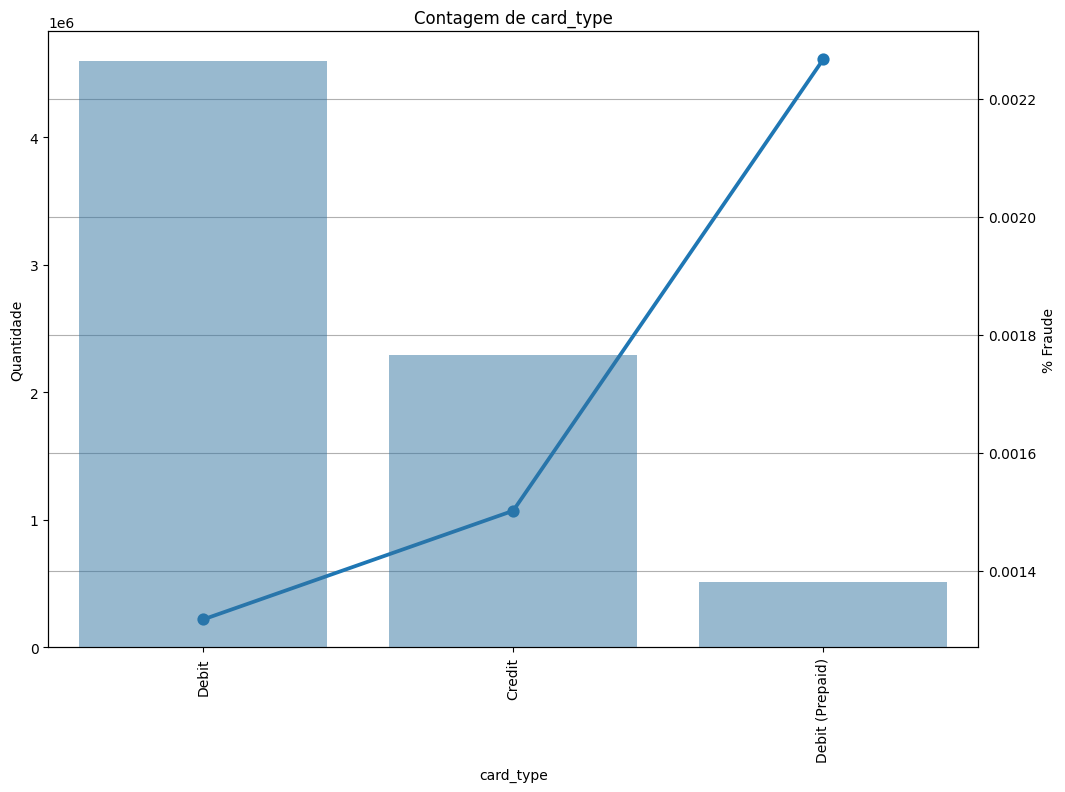

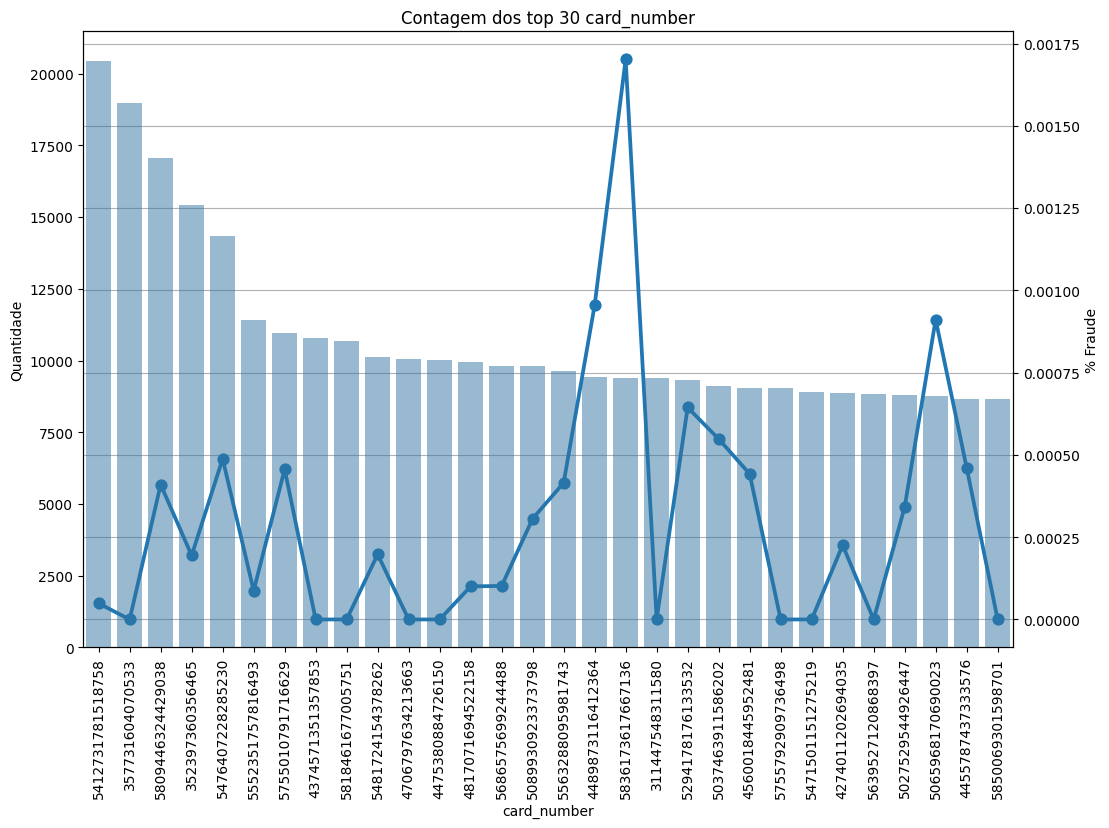

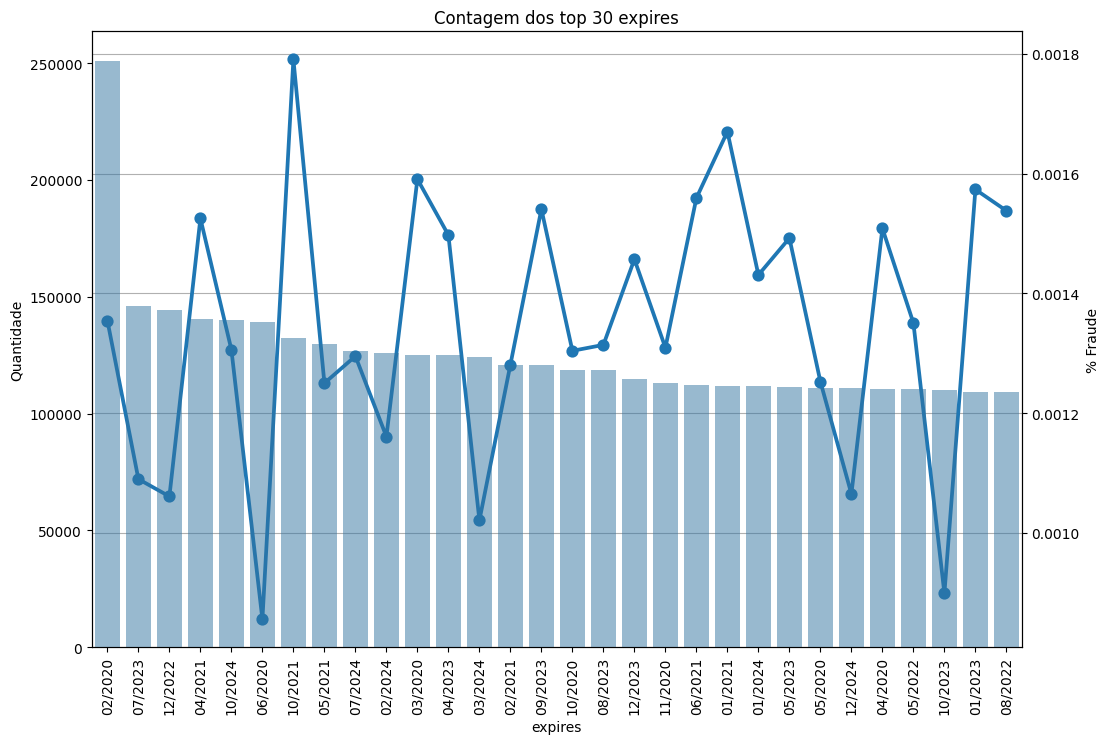

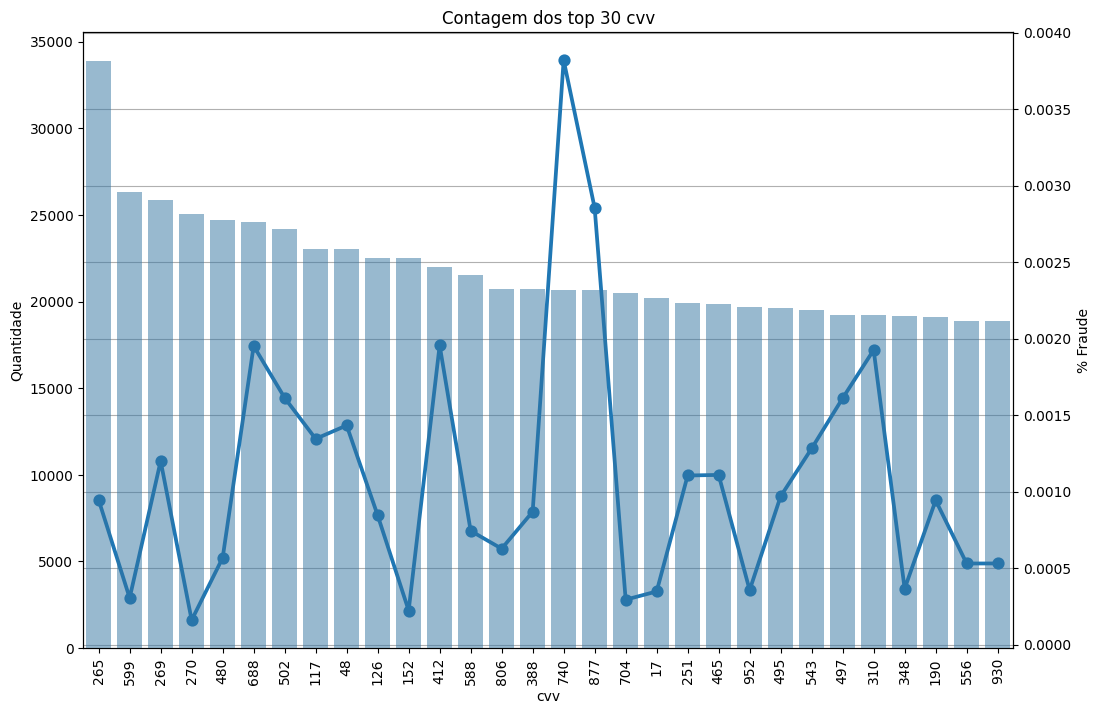

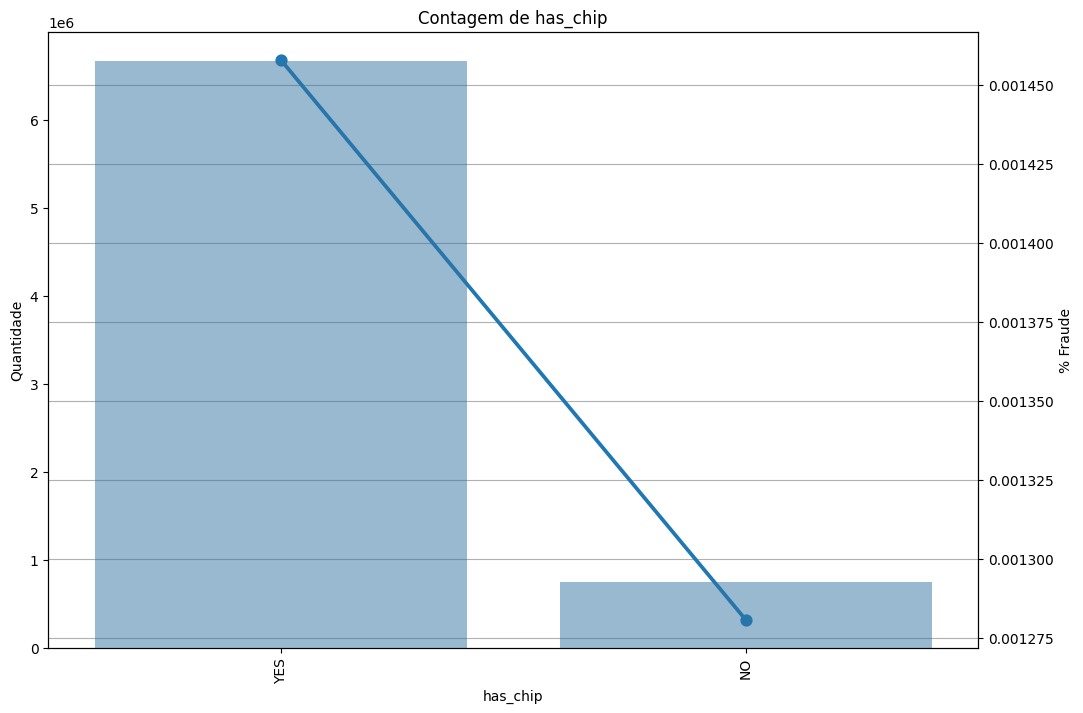

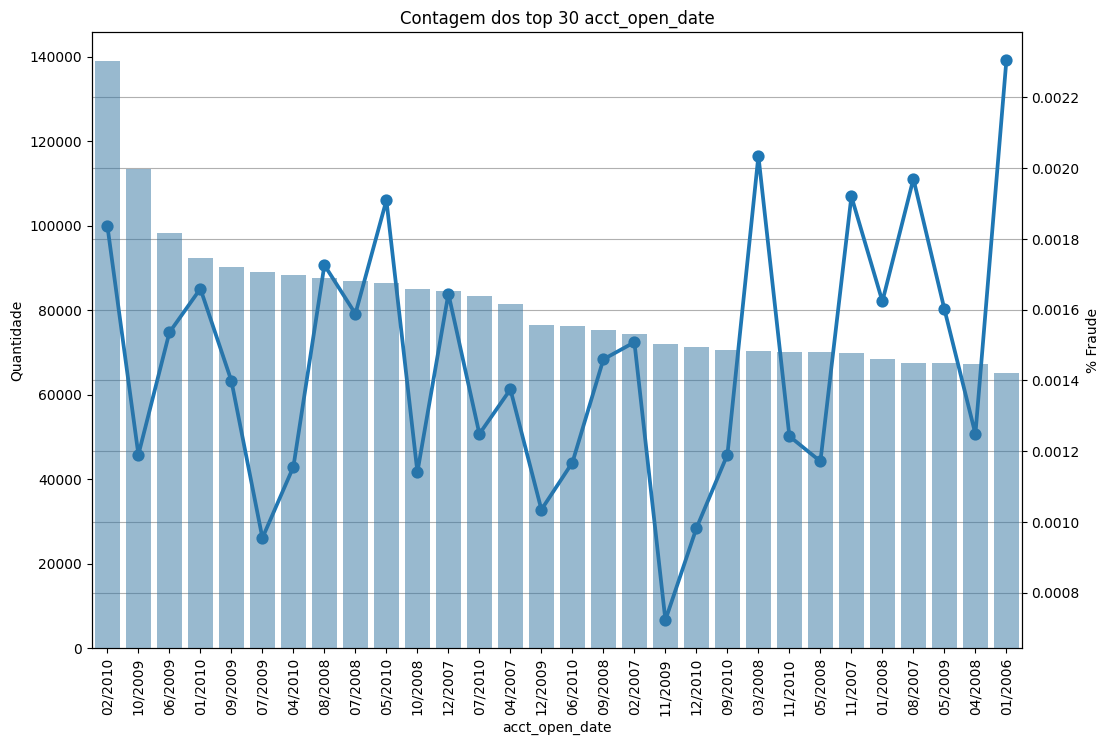

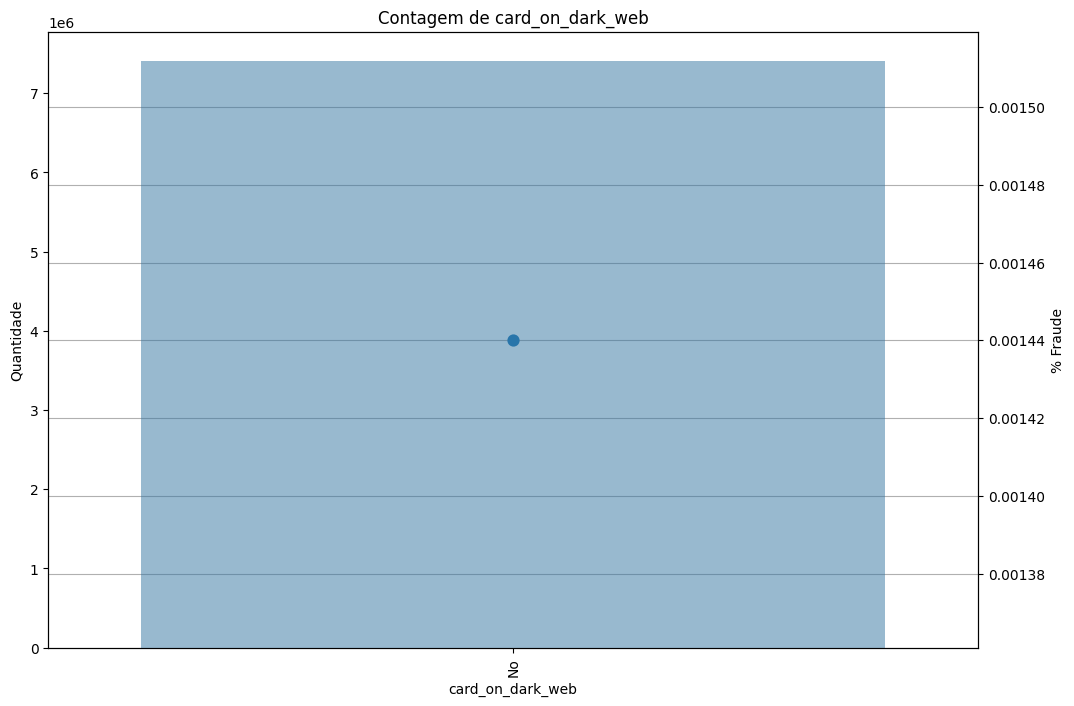

In [32]:
top = 30
for column in categorical_columns:
  plt.figure(figsize=(12,8))

  df_target = df.groupby(by=[column])['target'].value_counts(normalize=True).reset_index().query('target == "Yes"').drop(columns=['target'])
  df_target.columns = [column, 'percent']
  df_target = pd.merge(df[column].value_counts().reset_index(), df_target, on=column, how='left').fillna(0)

  title = f'Contagem de {column}'
  if len(df_target) > top:
    title = f'Contagem dos top {30} {column}'
    df_target = df_target.iloc[0:top]

  plt.title(title)
  ax = sns.barplot(data=df_target, x=column, y='count', alpha=0.5)
  ax.set_ylabel('Quantidade')
  ax.set_xlabel(column)
  ax.tick_params(axis='x', rotation=90)

  # for container in ax.containers:
  #   ax.bar_label(container, fmt='%d', label_type='edge', padding=5)

  ax2 = ax.twinx()
  ax2 = sns.pointplot(data=df_target, x=column, y='percent', ax=ax2)
  ax2.set_ylabel('% Fraude')

  ax.set_zorder(2)
  ax.patch.set_visible(False)

  plt.grid(True)
  plt.show()
  del df_target

In [33]:
df['merchant_state'].unique()

array(['ND', 'IA', 'CA', 'MD', 'NY', None, 'TX', 'HI', 'PA', 'GA', 'AL',
       'CT', 'WA', 'CO', 'NJ', 'FL', 'MT', 'AZ', 'KY', 'LA', 'OH', 'MI',
       'KS', 'MA', 'WI', 'NC', 'MO', 'AR', 'IL', 'IN', 'SC', 'TN', 'MN',
       'NV', 'OK', 'OR', 'NM', 'SD', 'WV', 'ME', 'VA', 'MS', 'DE', 'NH',
       'VT', 'Mexico', 'ID', 'NE', 'DC', 'UT', 'Vatican City', 'WY', 'RI',
       'Dominican Republic', 'Canada', 'AK', 'Costa Rica', 'Germany',
       'China', 'United Kingdom', 'Tuvalu', 'Taiwan',
       'United Arab Emirates', 'Netherlands', 'Lithuania', 'Japan',
       'Greece', 'Vietnam', 'Haiti', 'Ireland', 'Singapore', 'France',
       'South Africa', 'Thailand', 'Italy', 'Denmark', 'Jamaica', 'Benin',
       'Belgium', 'Sierra Leone', 'Indonesia', 'Colombia', 'Switzerland',
       'Portugal', 'New Zealand', 'Jordan', 'Guatemala', 'Hong Kong',
       'Finland', 'Mongolia', 'Saudi Arabia', 'Norway', 'Philippines',
       'Hungary', 'South Korea', 'Israel', 'India', 'Australia', 'Monaco',
     

In [34]:
df_cat = pd.DataFrame()
df_cat['use_chip'] = df['use_chip']
df_cat['is_merchant_city'] = df['merchant_city'].apply(lambda x: 'Yes' if str(x).lower() != 'online' else 'No')
df_cat['country'] = df['merchant_state'].apply(lambda x: 'United States' if x and len(x) == 2 else x)
df_cat['target'] = df['target']
df_cat.head()

use_chip is_merchant_city        country target
0  Swipe Transaction              Yes  United States     No
1  Swipe Transaction              Yes  United States     No
2  Swipe Transaction              Yes  United States     No
3  Swipe Transaction              Yes  United States     No
4  Swipe Transaction              Yes  United States     No

In [35]:
df.groupby(by='mcc')['target'].value_counts(normalize=True).reset_index().query('target == "Yes"').sort_values('proportion', ascending=False)

mcc target  proportion
74   4411    Yes    0.636364
131  5733    Yes    0.364706
8    3006    Yes    0.115942
129  5732    Yes    0.101781
24   3144    Yes    0.094444
..    ...    ...         ...
180  7802    Yes    0.000111
164  7230    Yes    0.000051
172  7538    Yes    0.000049
113  5541    Yes    0.000036
109  5499    Yes    0.000027

[98 rows x 3 columns]

In [36]:
df.groupby(by=['mcc', 'description'])['target'] \
  .value_counts(normalize=True) \
  .reset_index() \
  .query('target == "Yes" & proportion >= 0.05') \
  .sort_values('proportion', ascending=False) \
  .reset_index(drop=True)

mcc                               description target  proportion
0   4411                              Cruise Lines    Yes    0.636364
1   5733        Music Stores - Musical Instruments    Yes    0.364706
2   3006   Miscellaneous Fabricated Metal Products    Yes    0.115942
3   5732                        Electronics Stores    Yes    0.101781
4   3144                     Floor Covering Stores    Yes    0.094444
5   5045  Computers, Computer Peripheral Equipment    Yes    0.084424
6   3005           Miscellaneous Metal Fabrication    Yes    0.081731
7   3009      Fabricated Structural Metal Products    Yes    0.073394
8   4112                        Passenger Railways    Yes    0.068038
9   5816                     Digital Goods - Games    Yes    0.067925
10  3008                   Steel Drums and Barrels    Yes    0.060606
11  3007             Coated and Laminated Products    Yes    0.060465
12  5094                Precious Stones and Metals    Yes    0.056995

In [37]:
model = SentenceTransformer("all-MiniLM-L6-v2")

In [38]:
embeddings = model.encode(df['description'].unique().tolist())

In [39]:
reducer = umap.UMAP(n_components=5, min_dist=0.0, metric='cosine', random_state=42)
X_umap = reducer.fit_transform(embeddings)

In [40]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='euclidean')
labels = clusterer.fit_predict(X_umap)

In [41]:
map_category = {}
for category, label in zip(df['description'].unique().tolist(), labels):
    map_category[category] = label

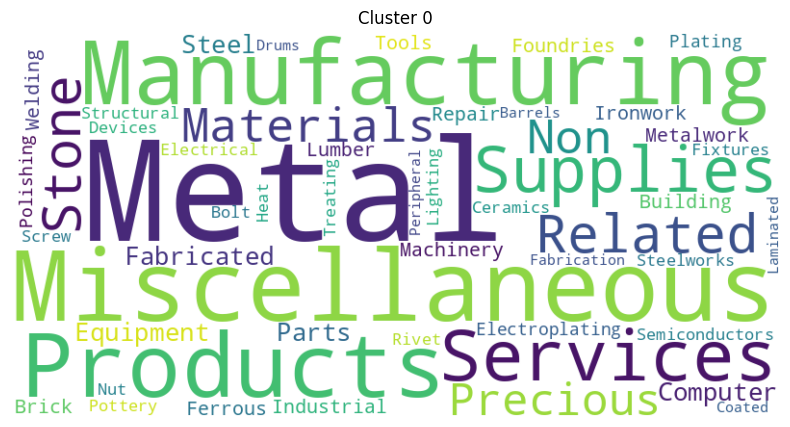

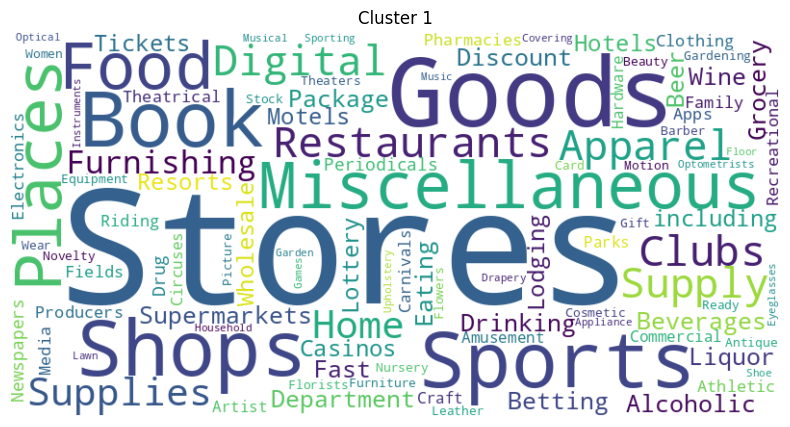

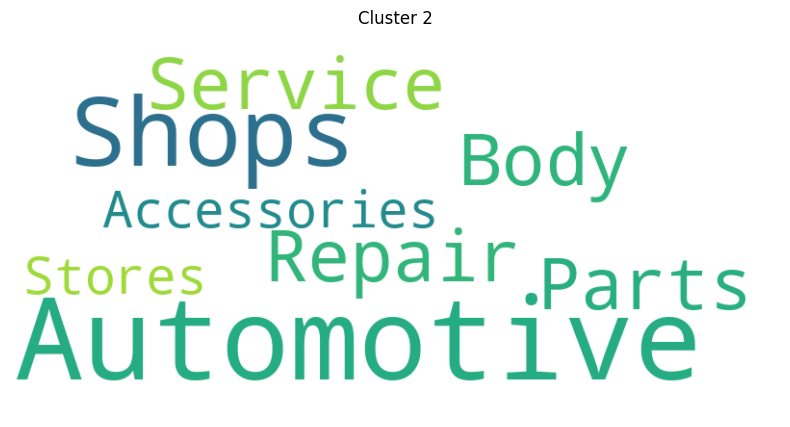

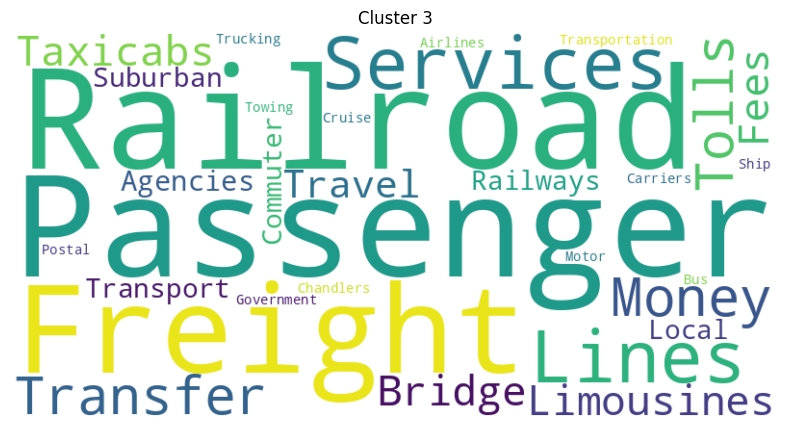

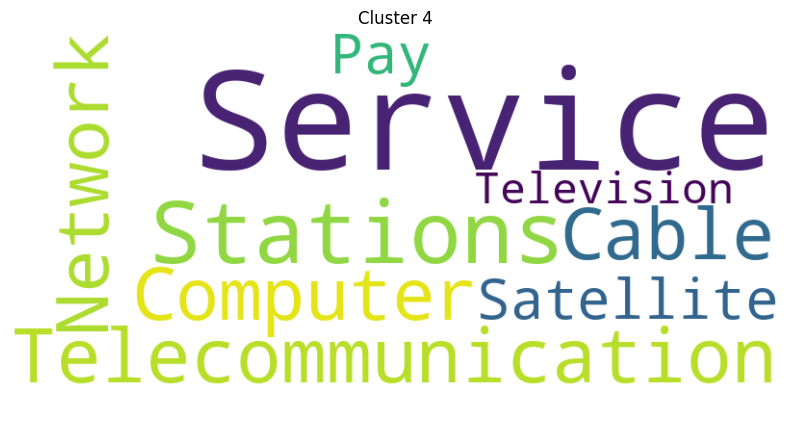

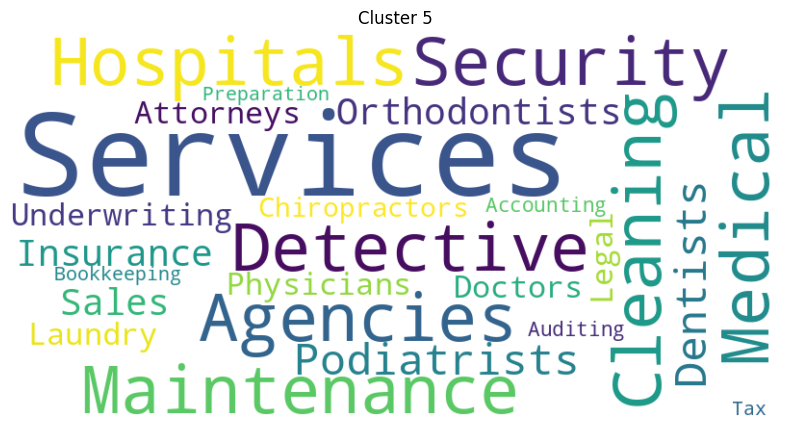

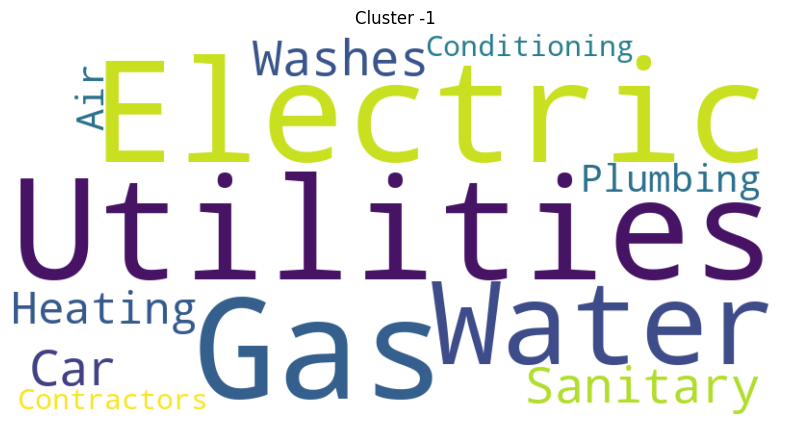

In [42]:
for map_value in set(map_category.values()):
  keys = [key for key, value in map_category.items() if value == map_value]
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(keys))

  plt.figure(figsize=(10, 5))
  plt.title(f'Cluster {map_value}')
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

In [43]:
df_cat['merchant_category'] = pd.Categorical(df['description'].map(map_category))
df_cat['gender'] = df['gender']
df_cat['card_brand'] = df['card_brand']
df_cat['card_type'] = df['card_type']
df_cat['has_chip'] = df['has_chip'].apply(lambda x: 'Yes' if str(x).lower() == 'yes' else 'No')

df_cat.head()

use_chip is_merchant_city        country target merchant_category  \
0  Swipe Transaction              Yes  United States     No                 1   
1  Swipe Transaction              Yes  United States     No                 1   
2  Swipe Transaction              Yes  United States     No                 3   
3  Swipe Transaction              Yes  United States     No                 1   
4  Swipe Transaction              Yes  United States     No                 1   

   gender  card_brand        card_type has_chip  
0  Female  Mastercard  Debit (Prepaid)      Yes  
1    Male  Mastercard           Credit      Yes  
2    Male  Mastercard            Debit      Yes  
3    Male        Visa            Debit      Yes  
4  Female  Mastercard  Debit (Prepaid)      Yes

In [44]:
for column in df_cat.drop(columns=['target']).columns:
    tabela = pd.crosstab(df_cat['target'], df_cat[column])

    print('\n')
    print(f"Tabela de contingência para {column}:")
    print(tabulate.tabulate(tabela, headers=df_cat[column].unique().tolist()))

    chi2, pvalor, gl, freq_esp = chi2_contingency(tabela)

    print(f"estatística qui²: {round(chi2, 2)}")
    print(f"p-valor da estatística: {round(pvalor, 4)}", "\n")



Tabela de contingência para use_chip:
       Swipe Transaction    Online Transaction    Chip Transaction
---  -------------------  --------------------  ------------------
No           2.13003e+06                853080         4.41159e+06
Yes        839                            8694      1132
estatística qui²: 50741.12
p-valor da estatística: 0.0 



Tabela de contingência para is_merchant_city:
        Yes              No
---  ------  --------------
No   855660     6.53904e+06
Yes    8694  1971
estatística qui²: 50533.64
p-valor da estatística: 0.0 



Tabela de contingência para country:
United States      None    Mexico    Vatican City    Dominican Republic    Canada    Costa Rica    Germany    China    United Kingdom    Tuvalu    Taiwan    United Arab Emirates    Netherlands    Lithuania    Japan    Greece    Vietnam    Haiti    Ireland    Singapore    France    South Africa    Thailand    Italy    Denmark    Jamaica    Benin    Belgium    Sierra Leone    Indonesia    Colombia 

In [ ]:
mca = prince.MCA(n_components=2, random_state=42).fit(df_cat.sample(frac=0.1).drop(columns=['has_chip', 'gender']))